### Importing Libraries

In [65]:
pip install lazypredict

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from imblearn.pipeline import Pipeline
from scipy.stats import zscore
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lazypredict.Supervised import LazyClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import TomekLinks
import warnings
warnings.filterwarnings("ignore")
import collections
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

## Know Your Data

In [67]:
data = pd.read_csv("credit_card_churn_dataset_V2.csv")
data = pd.DataFrame(data)

print(data.shape)

print(data.info())

data.head()

(20000, 55)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   index                               20000 non-null  int64  
 1   age                                 20000 non-null  int64  
 2   gender                              20000 non-null  object 
 3   marital_status                      20000 non-null  object 
 4   education_level                     10028 non-null  object 
 5   employment_status                   20000 non-null  object 
 6   num_dependents                      20000 non-null  int64  
 7   residence_type                      20000 non-null  object 
 8   years_at_residence                  20000 non-null  int64  
 9   monthly_spend_cash                  17985 non-null  float64
 10  monthly_spend_payments              18030 non-null  float64
 11  monthly_spend_installments   

index  age  gender marital_status education_level employment_status  \
0   5464   22    Male         Single          Master     Self-Employed   
1   2042   25    Male        Married             NaN           Retired   
2   8669   64  Female       Divorced        Bachelor          Employed   
3   1115   61  Female         Single          Master          Employed   
4   4078   58    Male        Married             NaN     Self-Employed   

   num_dependents residence_type  years_at_residence  monthly_spend_cash  ...  \
0               3           Rent                   3             4664.00  ...   
1               2           Rent                   1                 NaN  ...   
2               4            Own                   8             1408.00  ...   
3               2            Own                   8                 NaN  ...   
4               1           Rent                  14             4134.00  ...   

   credit_limit_utilization  average_payment_delay  monthly_active_days  \
0                      0.68                      0                 0.54   
1                      0.73                      0                 2.92   
2                      0.78                      0                 0.71   
3                      0.73                      0                 0.94   
4                      0.72                      3                 2.47   

   num_other_products  account_types  loyalty_score  transaction_frequency  \
0                   4           loan         251.70                     44   
1                  40       checking            NaN                     24   
2                   7       checking          93.90                     42   
3                   4           loan            NaN                     10   
4                   6       checking         266.70                     39   

   total_bank_balance  act_ref_num   plastic_masked_pan  
0           514953.50     SR010651  **** **** **** 4691  
1                 NaN     SR002042  **** **** **** 4806  
2           238569.72     SR008669  **** **** **** 2237  
3                 NaN     SR001115  **** **** **** 6982  
4           291044.97     SR013903  **** **** **** 5168  

[5 rows x 55 columns]

Our data set consists of 20000 rows (cases) and 56 columns (features). Which are divided into 23 float (continuous numeric values), 24 int (discrete numeric), 10 object (categorical values)

### Understanding categorical data

In [68]:
gender = data['gender']
marital_status = data['marital_status']
education_level = data['education_level']
employment_status = data['employment_status']
residence_type = data['residence_type']
spend_volatility = data['spend_volatility']
expiration_date = data['expiration_date']
account_types = data['account_types']
act_ref_num = data['act_ref_num']
plastic_masked_pan = data['plastic_masked_pan']

categorical_features = [
    ('Gender Types', gender),
    ('Marital Status', marital_status),
    ('Educational Level', education_level),
    ('Employment Status', employment_status),
    ('Residence Type', residence_type),
    ('Spend Volatility', spend_volatility),
    # ('Expiration Date', expiration_date),
    ('Account Types', account_types),
    # ('Account Reference Number', act_ref_num),
    # ('Plastic Masked PAN', plastic_masked_pan)
]

for feature_name, feature_data in categorical_features:
    print(f'{feature_name}:', feature_data.unique())

Gender Types: ['Male' 'Female']
Marital Status: ['Single' 'Married' 'Divorced' 'Widowed']
Educational Level: ['Master' nan 'Bachelor' 'High School' 'PhD']
Employment Status: ['Self-Employed' 'Retired' 'Employed']
Residence Type: ['Rent' 'Own']
Spend Volatility: ['High' 'Low' 'Medium']
Account Types: ['loan' 'checking' 'savings' 'investment']


### Understanding numeric data

In [69]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
for feature in numeric_features:
    print(f'Description for {feature}:')
    print(data[feature].describe())
    print('\n')

Description for index:
count   20000.00
mean     4990.93
std      2883.84
min         1.00
25%      2505.00
50%      4982.00
75%      7494.00
max     10000.00
Name: index, dtype: float64


Description for age:
count   20000.00
mean       43.44
std        14.92
min        18.00
25%        31.00
50%        43.00
75%        56.00
max        69.00
Name: age, dtype: float64


Description for num_dependents:
count   20000.00
mean        2.00
std         1.41
min         0.00
25%         1.00
50%         2.00
75%         3.00
max         4.00
Name: num_dependents, dtype: float64


Description for years_at_residence:
count   20000.00
mean       14.99
std         8.35
min         1.00
25%         8.00
50%        15.00
75%        22.00
max        29.00
Name: years_at_residence, dtype: float64


Description for monthly_spend_cash:
count   17985.00
mean     2517.59
std      1445.05
min         0.00
25%      1281.00
50%      2489.00
75%      3803.00
max      4999.00
Name: monthly_spend_cash, dtype:

# EDA

### Visualize categorical data

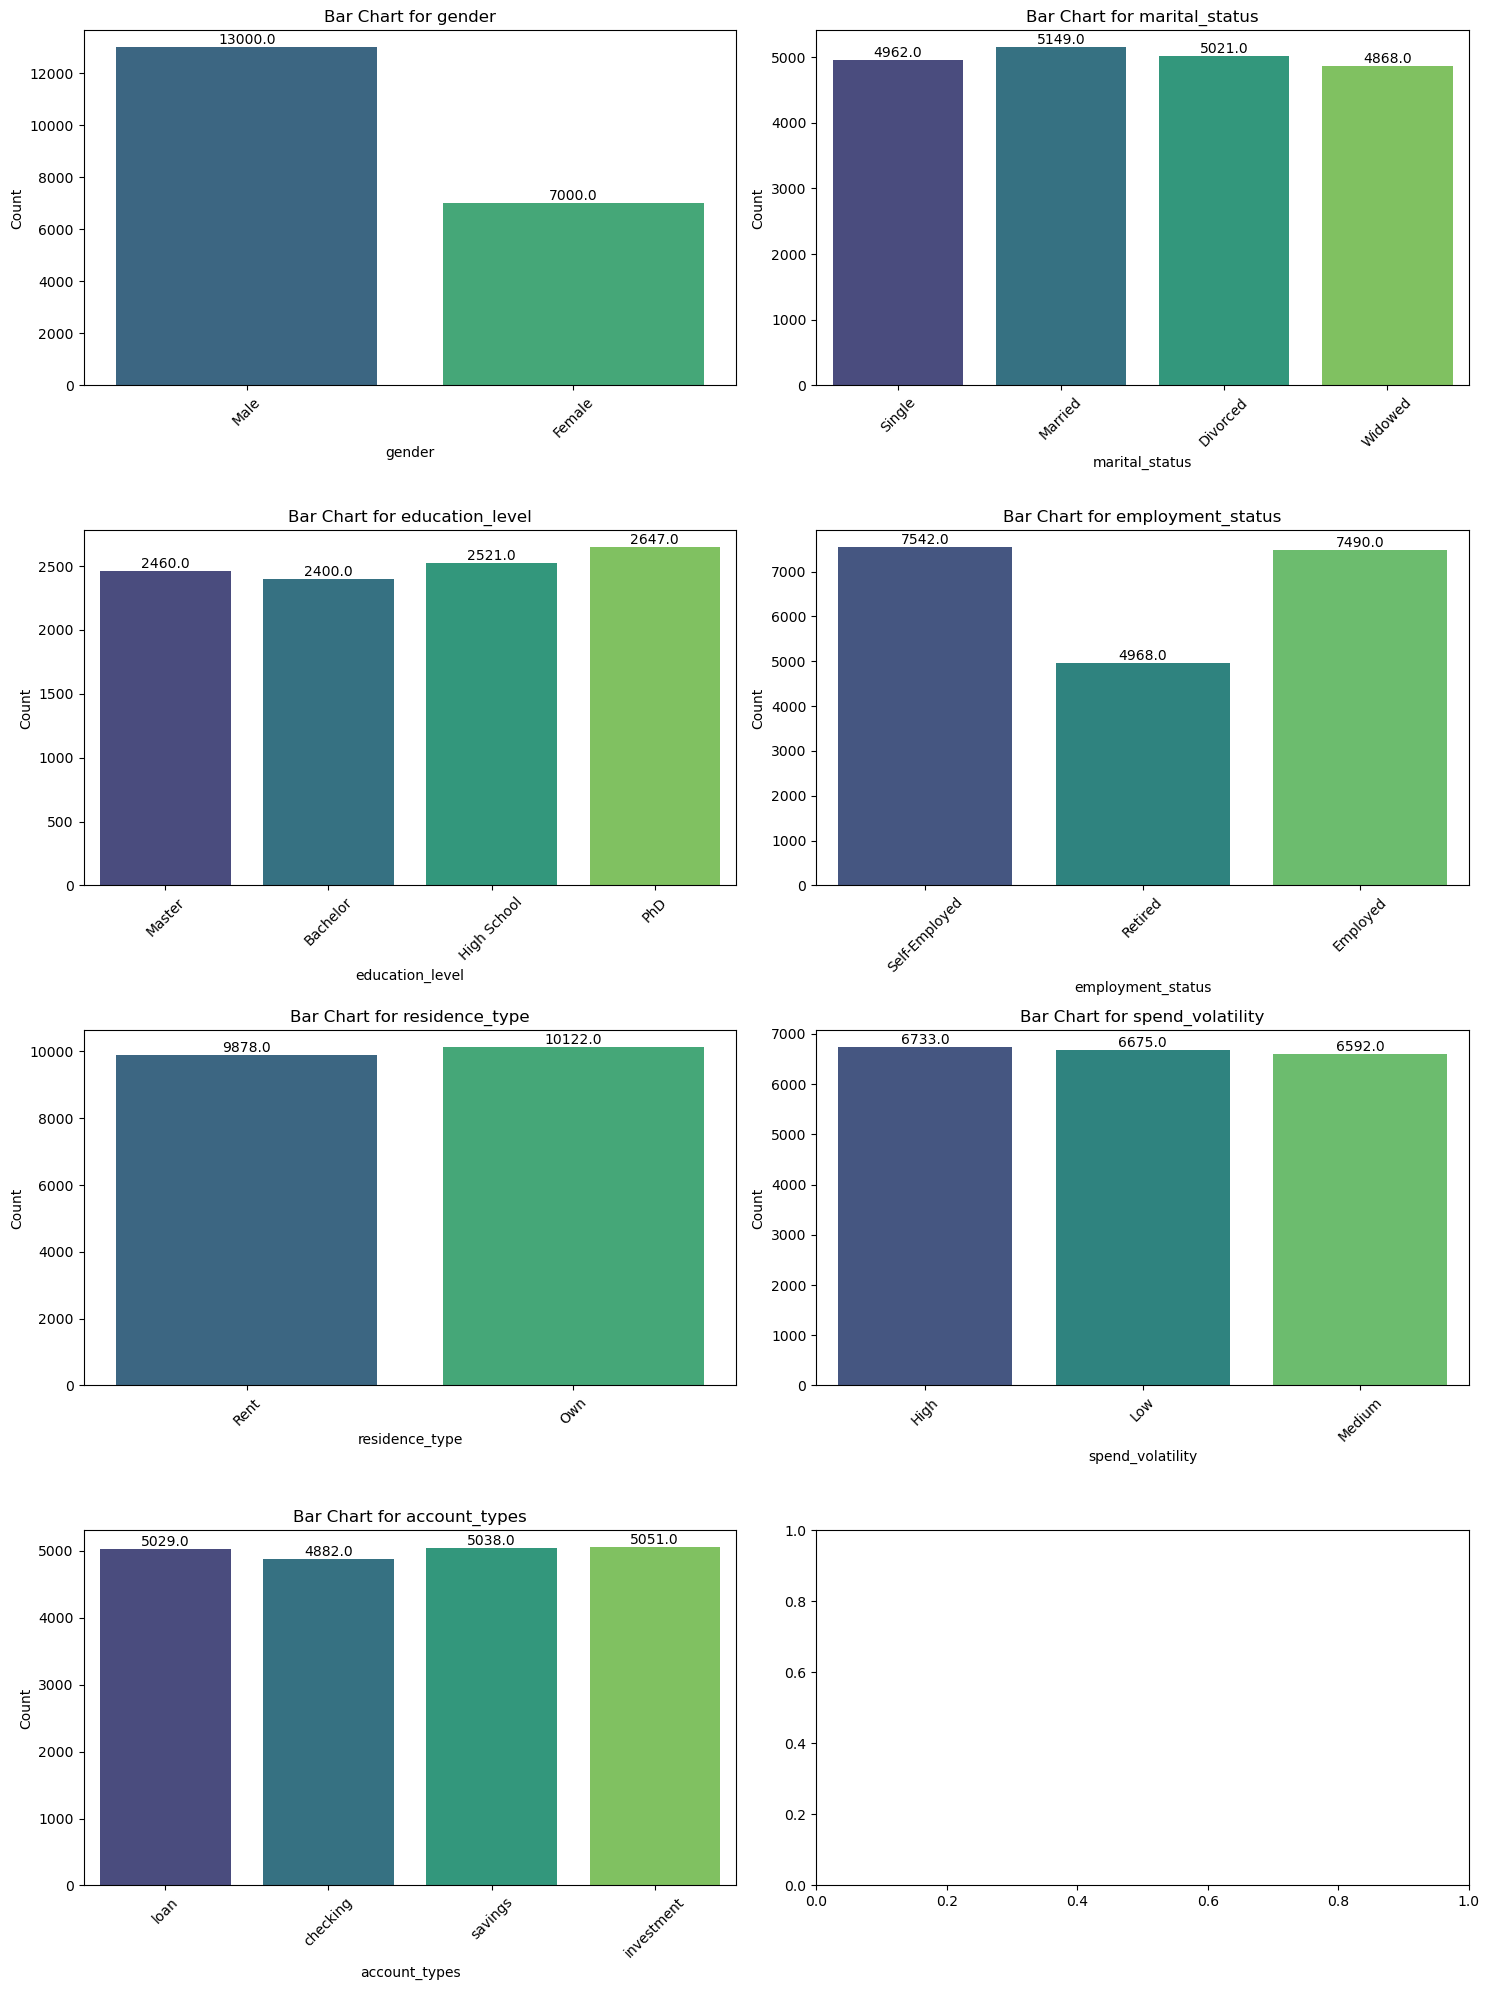

In [70]:
temp_df = data.copy()

categorical_features = [
    'gender', 'marital_status', 'education_level', 'employment_status',
    'residence_type', 'spend_volatility','account_types'
]

num_features = len(categorical_features)
num_cols = 2
num_rows = (num_features + 1) // 2 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    if feature in temp_df.columns:
        ax = axs[i]
        sns.countplot(x=feature, data=data, palette='viridis', ax=ax)

        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
        ax.set_title(f'Bar Chart for {feature}')
        ax.set_xlabel(feature)
        ax.set_ylabel('Count')
        ax.tick_params(axis='x', rotation=45)
    else:
        print(f"Feature '{feature}' does not exist in the DataFrame.")
plt.tight_layout()
plt.show()

## Visulaize numerical values

### Age

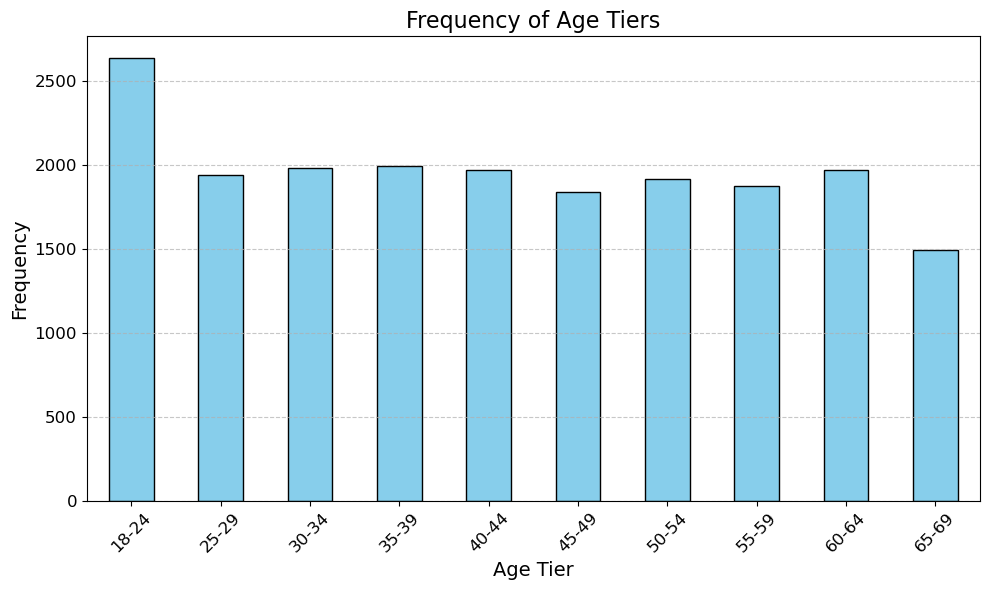

In [71]:
age_bins = [18,25,30,35,40,45,50,55,60,65,70]
age_labels = ['18-24','25-29','30-34', '35-39','40-44','45-49', '50-54','55-59', '60-64','65-69']

# Add a new column 'Age Tier' to temporary DataFrame
temp_df['age_tier'] = pd.cut(temp_df['age'], bins=age_bins, labels=age_labels)

age_tier_counts = temp_df['age_tier'].value_counts().sort_index()

# Plot bar chart
plt.figure(figsize=(10, 6))
age_tier_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Frequency of Age Tiers', fontsize=16)
plt.xlabel('Age Tier', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

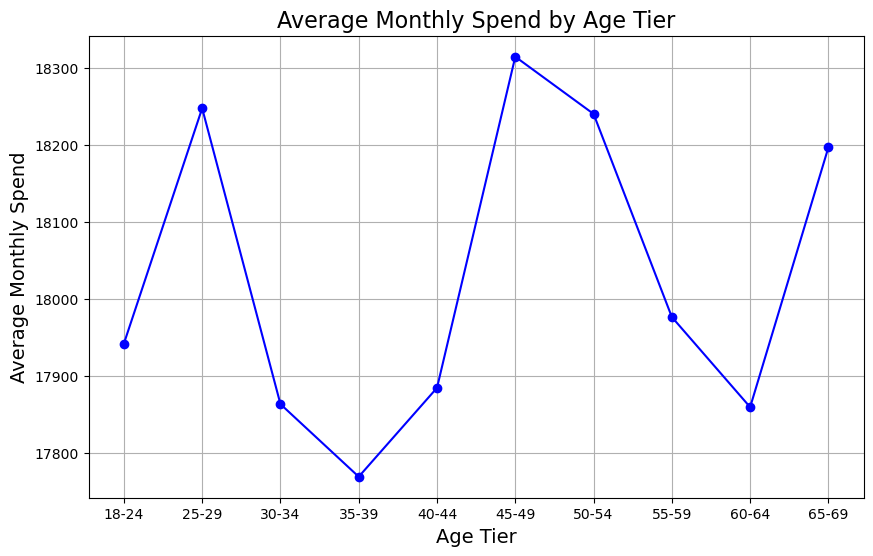

In [72]:
age_tier_spend = temp_df.groupby('age_tier')['average_monthly_spend'].mean().reset_index()

# Plotting the line plot
plt.figure(figsize=(10, 6))
plt.plot(age_tier_spend['age_tier'], age_tier_spend['average_monthly_spend'], marker='o', linestyle='-', color='b')

# Adding labels and title
plt.title('Average Monthly Spend by Age Tier', fontsize=16)
plt.xlabel('Age Tier', fontsize=14)
plt.ylabel('Average Monthly Spend', fontsize=14)
plt.grid(True)

# Display the plot
plt.show()

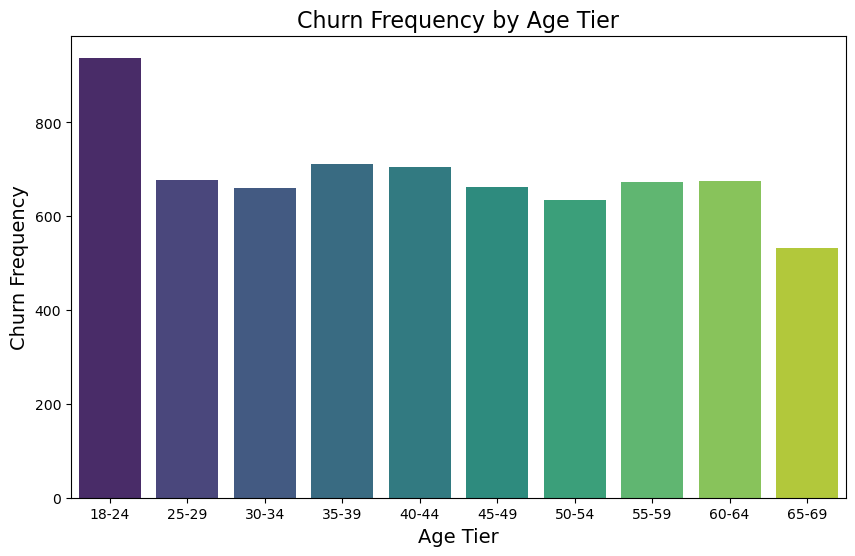

In [73]:
churn_frequency = temp_df.groupby('age_tier')['churn'].sum().reset_index()

# Plotting the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='age_tier', y='churn', data=churn_frequency, palette="viridis")

# Adding labels and title
plt.title('Churn Frequency by Age Tier', fontsize=16)
plt.xlabel('Age Tier', fontsize=14)
plt.ylabel('Churn Frequency', fontsize=14)

# Display the plot
plt.show()

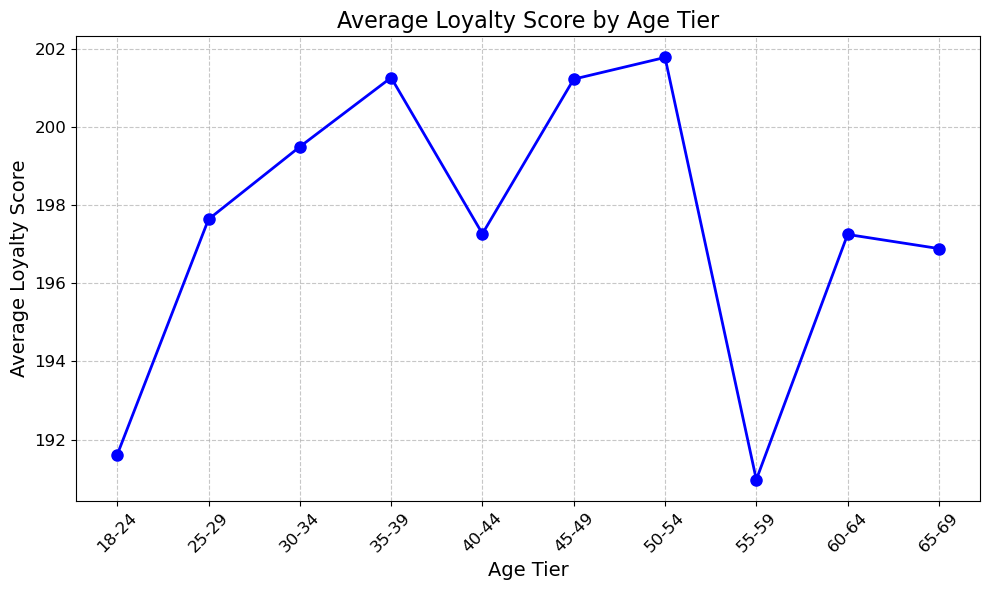

In [74]:
avg_loyalty_score = temp_df.groupby('age_tier')['loyalty_score'].mean()

# Plot line chart
plt.figure(figsize=(10, 6))
plt.plot(avg_loyalty_score.index, avg_loyalty_score.values, marker='o', linestyle='-', color='b', linewidth=2, markersize=8)
plt.title('Average Loyalty Score by Age Tier', fontsize=16)
plt.xlabel('Age Tier', fontsize=14)
plt.ylabel('Average Loyalty Score', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

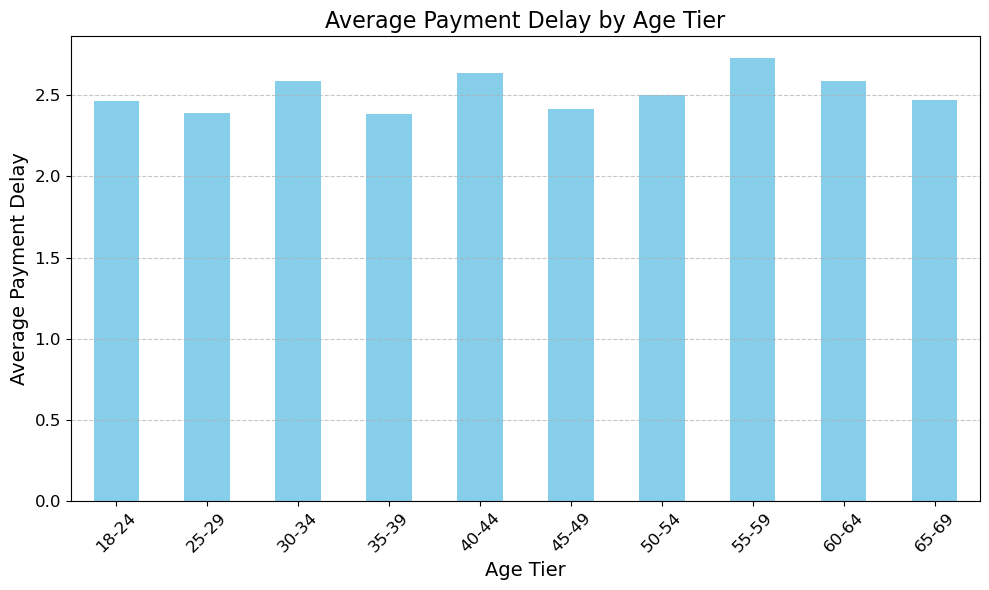

In [75]:
avg_payment_delay = temp_df.groupby('age_tier')['average_payment_delay'].mean()

# Plot bar chart
plt.figure(figsize=(10, 6))
avg_payment_delay.plot(kind='bar', color='skyblue')
plt.title('Average Payment Delay by Age Tier', fontsize=16)
plt.xlabel('Age Tier', fontsize=14)
plt.ylabel('Average Payment Delay', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [76]:
# Calculate total customers and churned customers for each age tier
age_tier_counts = temp_df['age_tier'].value_counts().sort_index()

# Calculate churned customers by age tier
churned_customers_by_age_tier = temp_df.groupby('age_tier')['churn'].sum().sort_index()

# Calculate churn rate for each age tier
churn_rate_by_age_tier = (churned_customers_by_age_tier / age_tier_counts) * 100

# Print churn rate for each age tier
print("Churn Rate by Age Tier:")
for age_tier, churn_rate in churn_rate_by_age_tier.items():
    print(f"{age_tier}: {churn_rate:.2f}%")

Churn Rate by Age Tier:
18-24: 35.57%
25-29: 34.84%
30-34: 33.30%
35-39: 35.71%
40-44: 35.75%
45-49: 35.98%
50-54: 33.07%
55-59: 35.97%
60-64: 34.28%
65-69: 35.63%


We can conclude that age has fairly normal distribution

### Martial Status

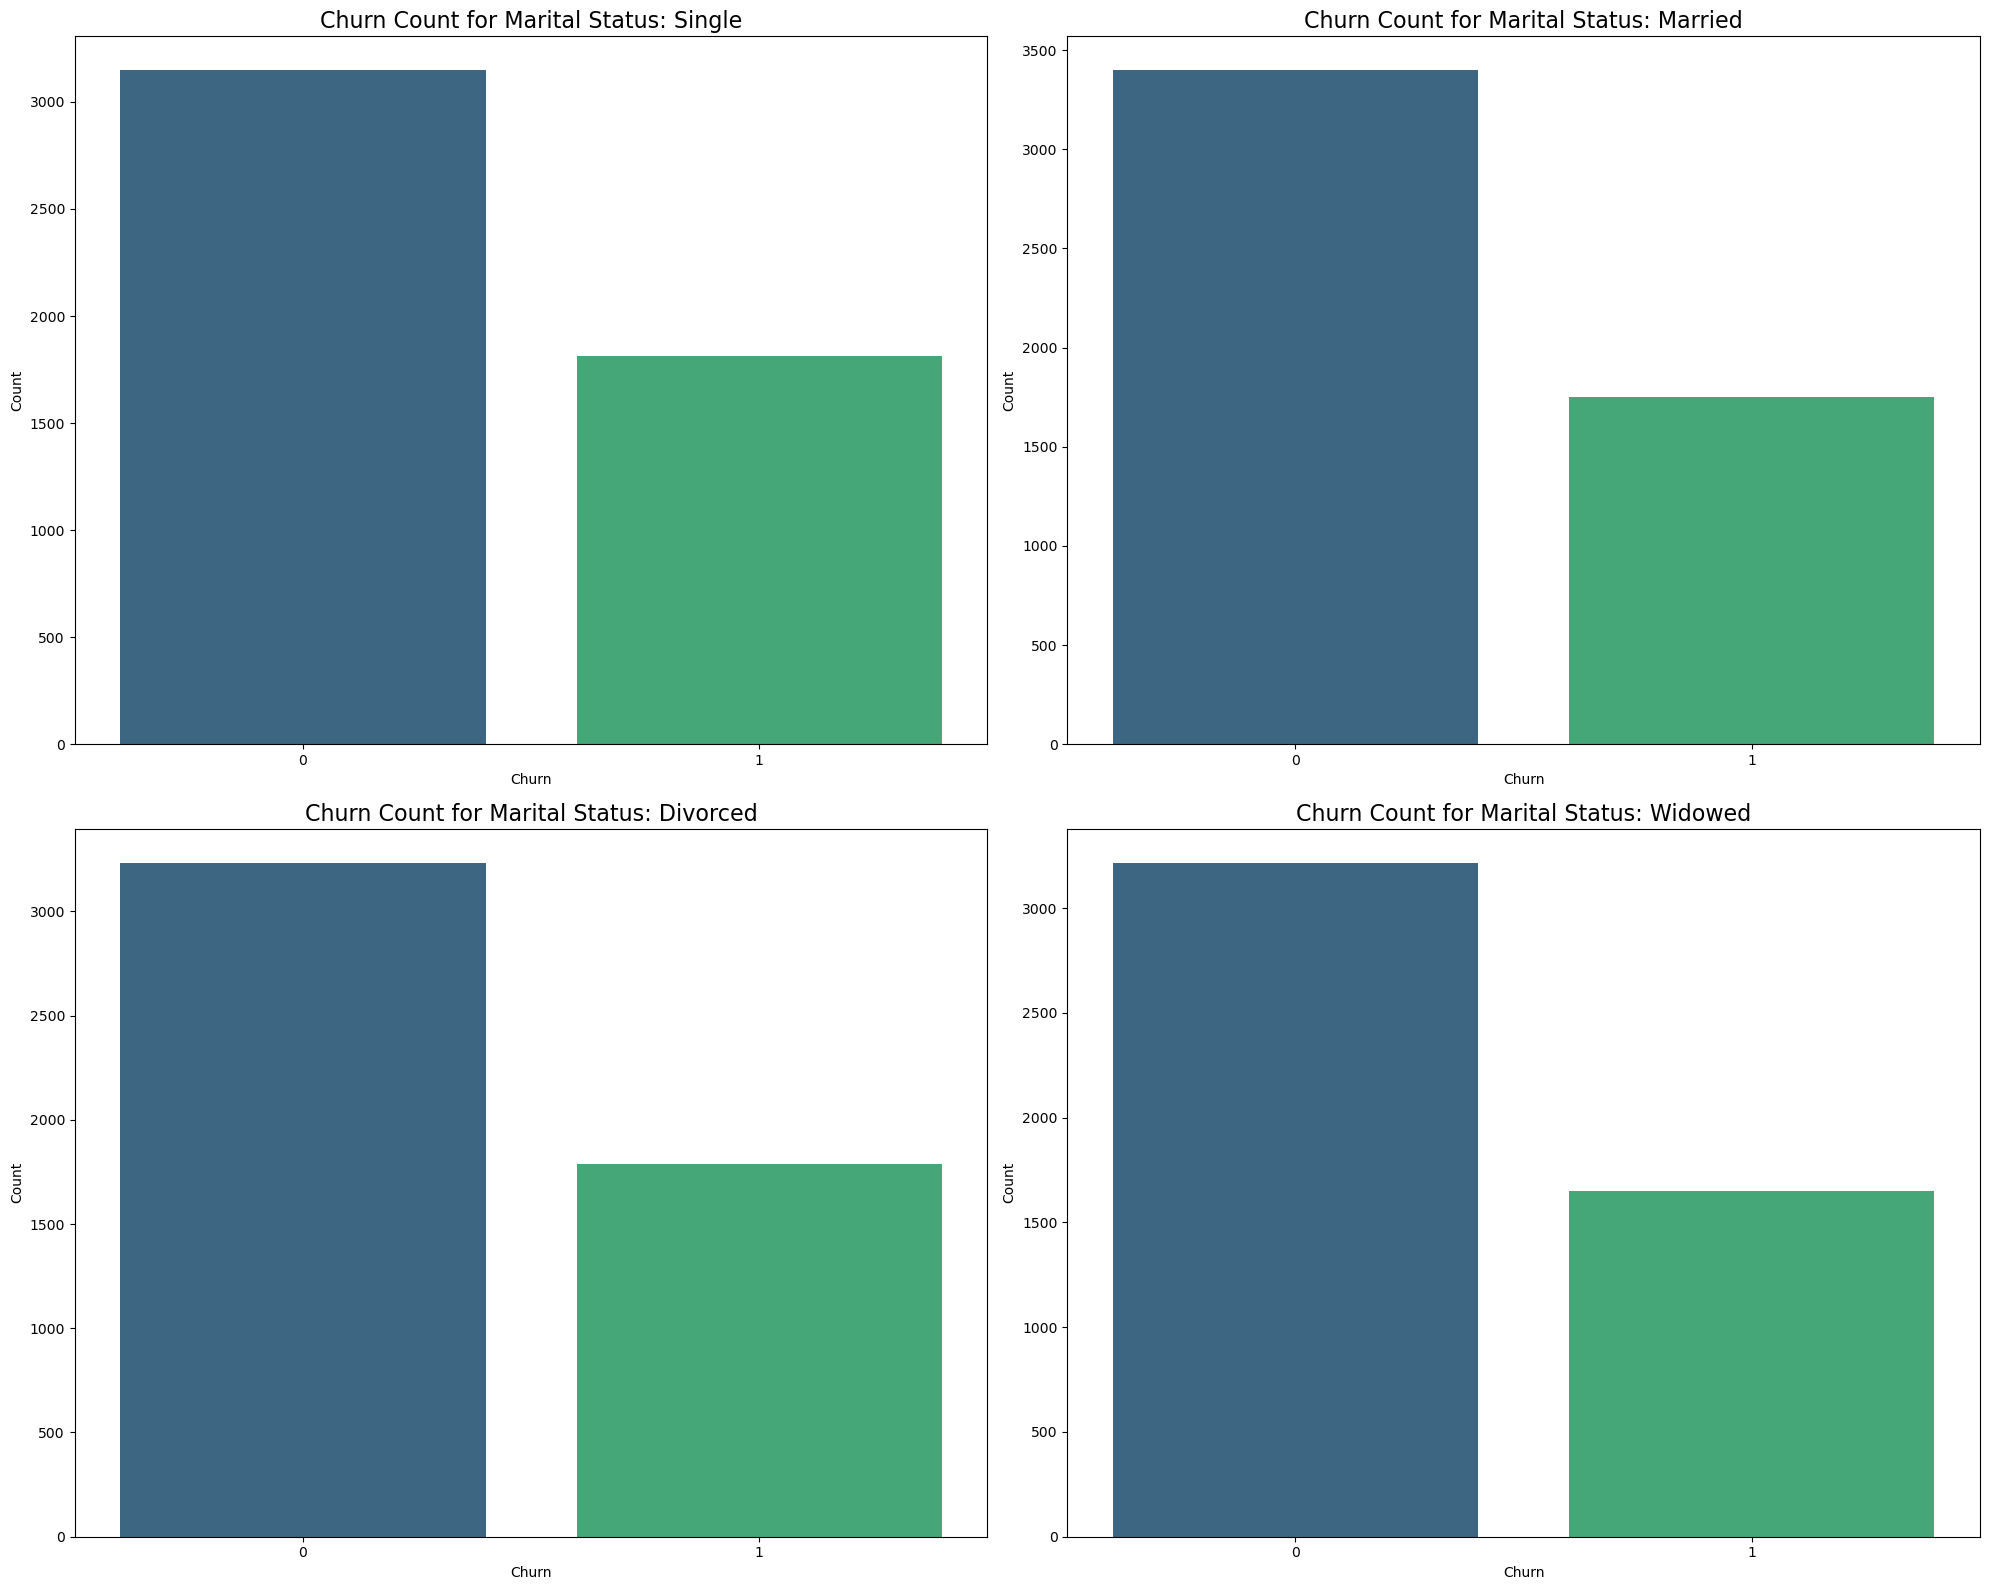

In [77]:
marital_statuses = temp_df['marital_status'].unique()
plt.figure(figsize=(20, 16))

for i, status in enumerate(marital_statuses):
    plt.subplot(2, 2, i+1)
    
    status_data = temp_df[temp_df['marital_status'] == status]
    
    churn_counts = status_data['churn'].value_counts()
    
    sns.barplot(x=churn_counts.index, y=churn_counts.values, palette='viridis')
    
    plt.title(f'Churn Count for Marital Status: {status}', fontsize=16)
    plt.xlabel('Churn')
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [78]:
marital_statuses = temp_df['marital_status'].unique()

for status in marital_statuses:
    status_data = temp_df[temp_df['marital_status'] == status]
    churn_rate = (status_data['churn'].sum() / status_data.shape[0]) * 100
    print(f"Churn rate for {status}: {churn_rate:.2f}%")

Churn rate for Single: 36.54%
Churn rate for Married: 33.99%
Churn rate for Divorced: 35.59%
Churn rate for Widowed: 33.89%


In [79]:
employment_status_counts = temp_df['employment_status'].value_counts().sort_index()

churned_customers_by_employment_status = temp_df.groupby('employment_status')['churn'].sum().sort_index()

churn_rate_by_employment_status = (churned_customers_by_employment_status / employment_status_counts) * 100

print("Churn Rate by Employment Status:")
for employment_status, churn_rate in churn_rate_by_employment_status.items():
    print(f"{employment_status}: {churn_rate:.2f}%")

Churn Rate by Employment Status:
Employed: 35.13%
Retired: 35.71%
Self-Employed: 34.41%


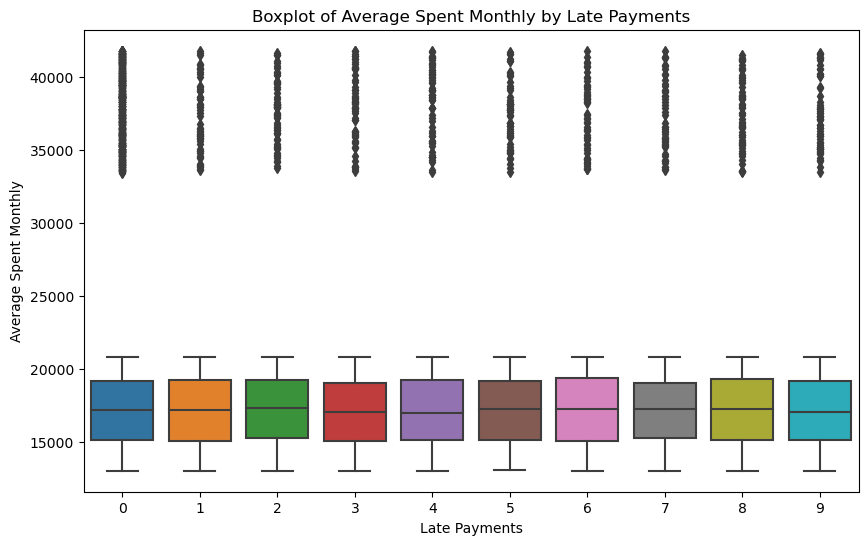

In [80]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='average_payment_delay', y='average_monthly_spend', data=temp_df)

plt.title('Boxplot of Average Spent Monthly by Late Payments')
plt.xlabel('Late Payments')
plt.ylabel('Average Spent Monthly')

plt.show()

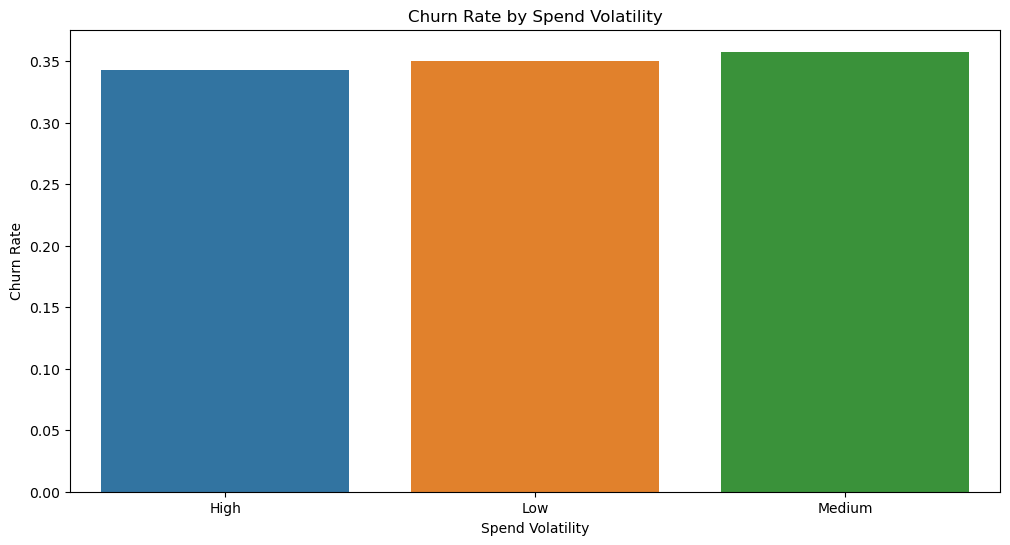

In [81]:
spend_volatility_churn = temp_df.groupby('spend_volatility')['churn'].mean().reset_index()

spend_volatility_churn.columns = ['spend_volatility', 'churn_rate']

plt.figure(figsize=(12, 6))

sns.barplot(x='spend_volatility', y='churn_rate', data=spend_volatility_churn)

plt.title('Churn Rate by Spend Volatility')
plt.xlabel('Spend Volatility')
plt.ylabel('Churn Rate')
plt.show()

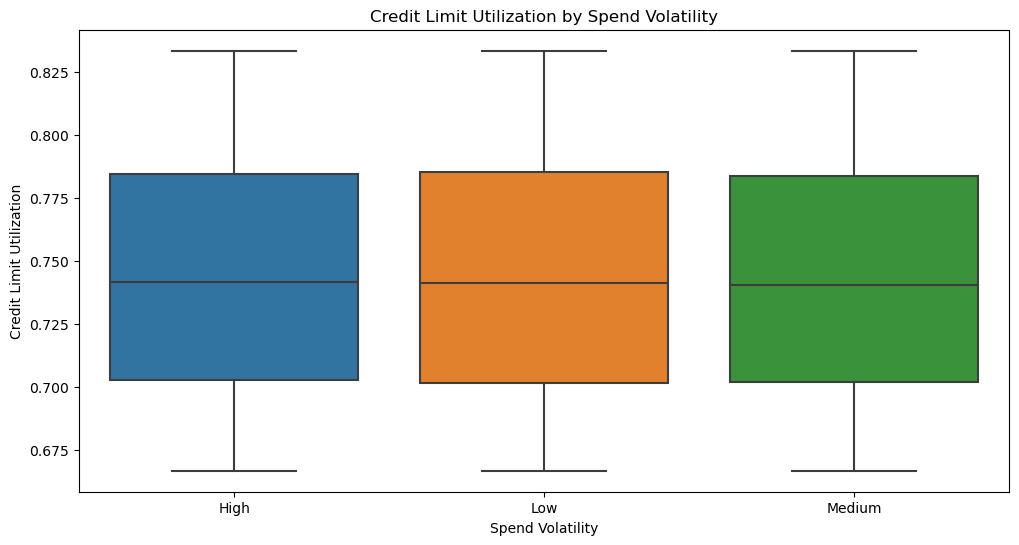

In [82]:
plt.figure(figsize=(12, 6))

sns.boxplot(x='spend_volatility', y='credit_limit_utilization', data=temp_df)

plt.title('Credit Limit Utilization by Spend Volatility')
plt.xlabel('Spend Volatility')
plt.ylabel('Credit Limit Utilization')

plt.show()

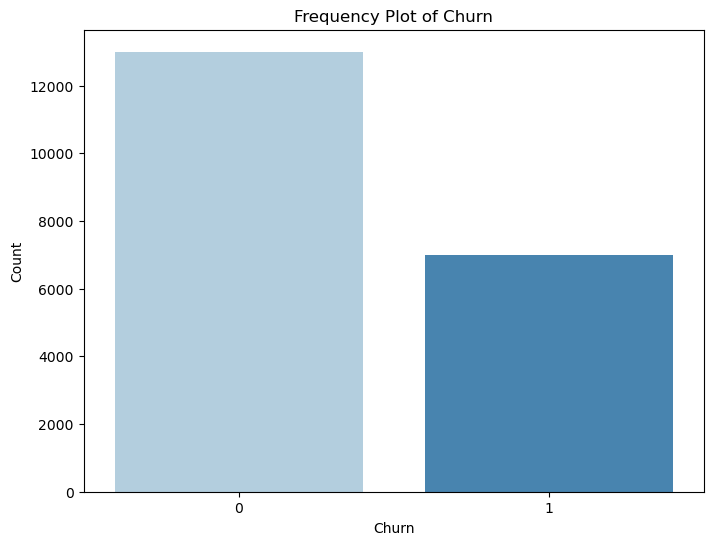

Churn Percentages:
0   65.00
1   35.00
Name: churn, dtype: float64


In [83]:
plt.figure(figsize=(8, 6))
sns.countplot(x='churn', data=temp_df, palette='Blues')
plt.title('Frequency Plot of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

# Calculate the percentage of people with churn 0 and 1
churn_counts = temp_df['churn'].value_counts()
churn_percentages = (churn_counts / len(temp_df)) * 100

print("Churn Percentages:")
print(churn_percentages)

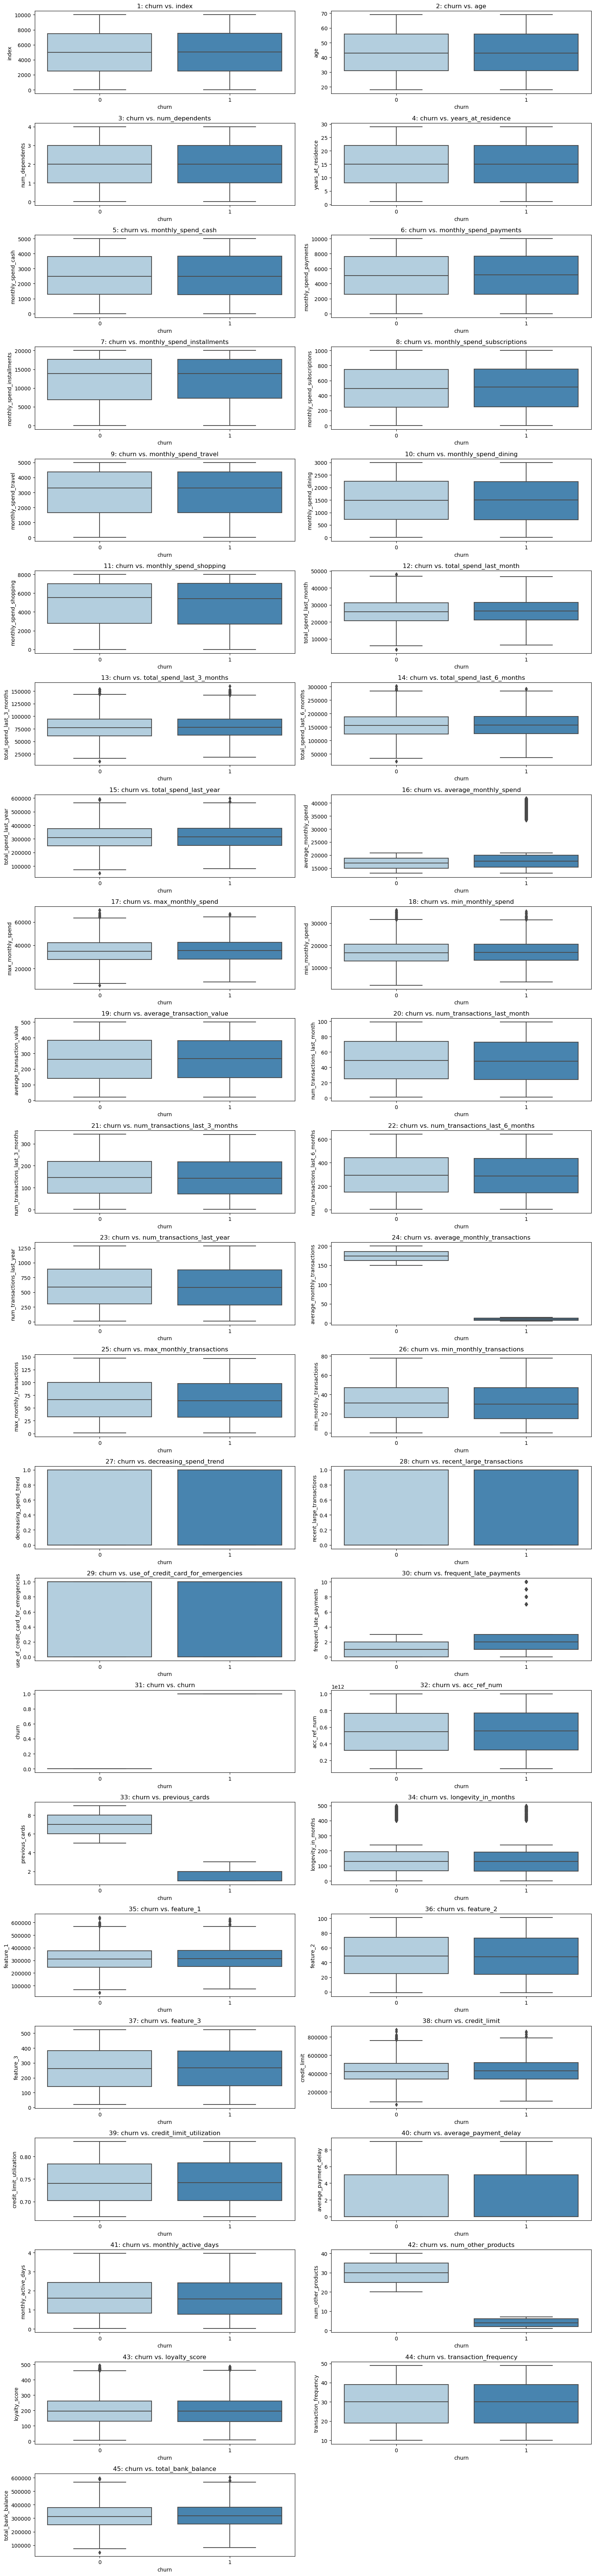

In [84]:
def box_by_target(temp_df, numeric_columns, target, include_outliers):
    subplot_cols = 2
    subplot_rows = int(len(numeric_columns) / 2 + 1)
    plt.figure(figsize=(16, 3 * subplot_rows))
    for i, col in enumerate(numeric_columns):
        plt.subplot(subplot_rows, subplot_cols, i + 1)
        sns.boxplot(
            data=temp_df,
            x=target,
            y=col,
            orient="vertical",
            palette="Blues",
            showfliers=include_outliers,
        )
        plt.tight_layout()
        plt.title(f"{i + 1}: {target} vs. {col}", color="black")

# Select only numeric columns
numeric_columns = temp_df.select_dtypes(include=["float64", "int64"]).columns.tolist()
target_variable = "churn"
box_by_target(temp_df, numeric_columns, target_variable, True)

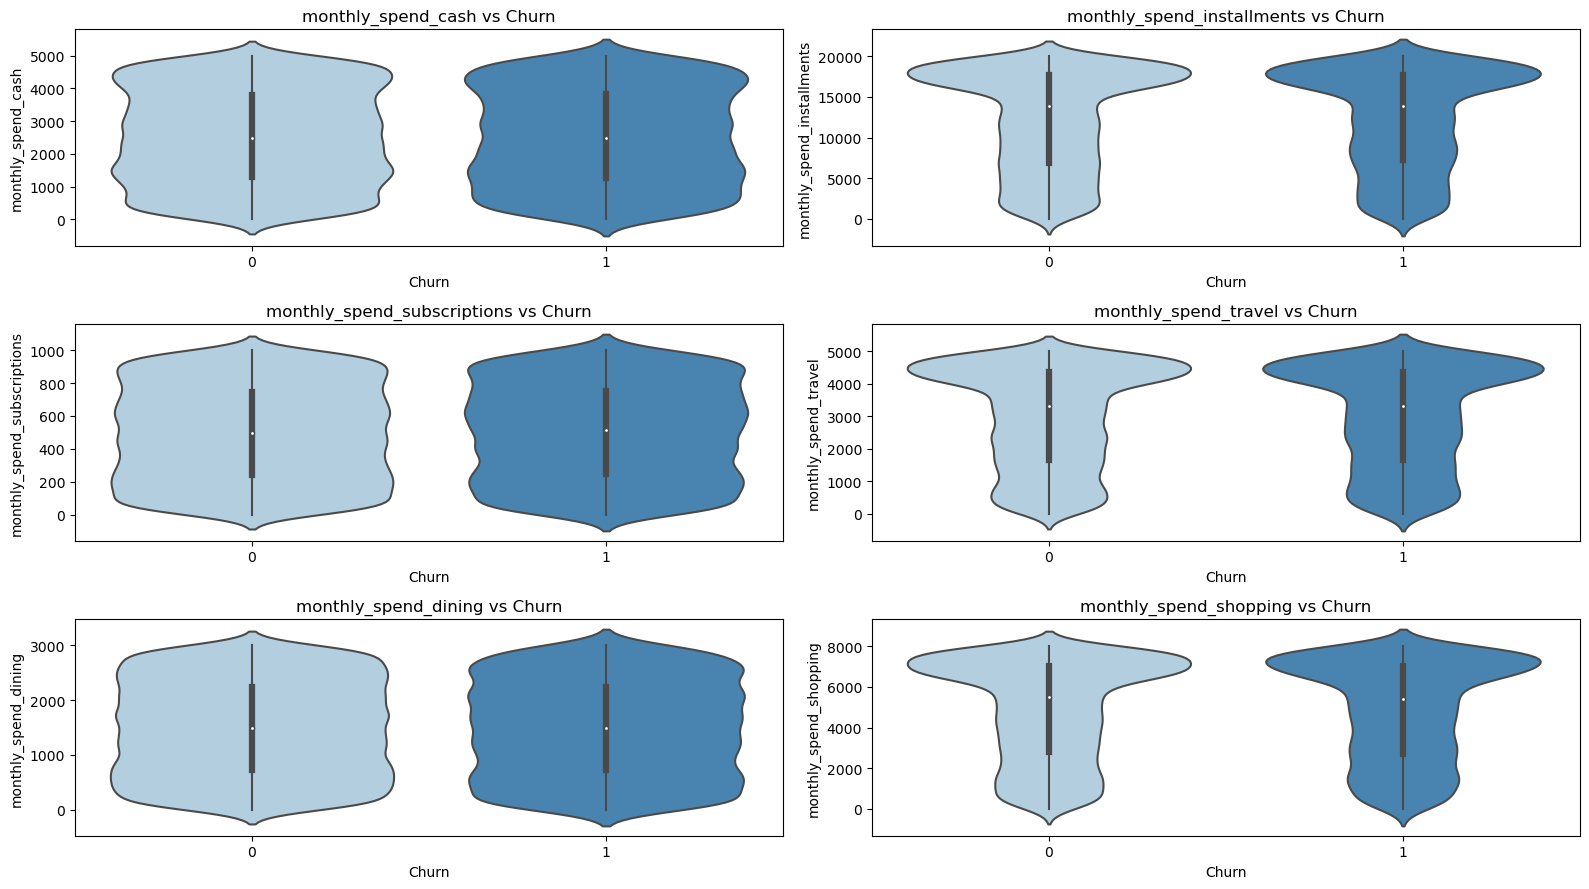

In [85]:
spending_features = [
    'monthly_spend_cash', 'monthly_spend_installments', 'monthly_spend_subscriptions', 
    'monthly_spend_travel', 'monthly_spend_dining', 'monthly_spend_shopping'
]

# Number of subplots needed
n_features = len(spending_features)
subplot_cols = 2
subplot_rows = int(n_features / subplot_cols) + (n_features % subplot_cols)

# Set up the matplotlib figure
plt.figure(figsize=(16, 3 * subplot_rows))

# Create violin plots
for i, feature in enumerate(spending_features):
    plt.subplot(subplot_rows, subplot_cols, i + 1)
    sns.violinplot(x='churn', y=feature, data=temp_df, palette='Blues')
    plt.title(f'{feature} vs Churn')
    plt.xlabel('Churn')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

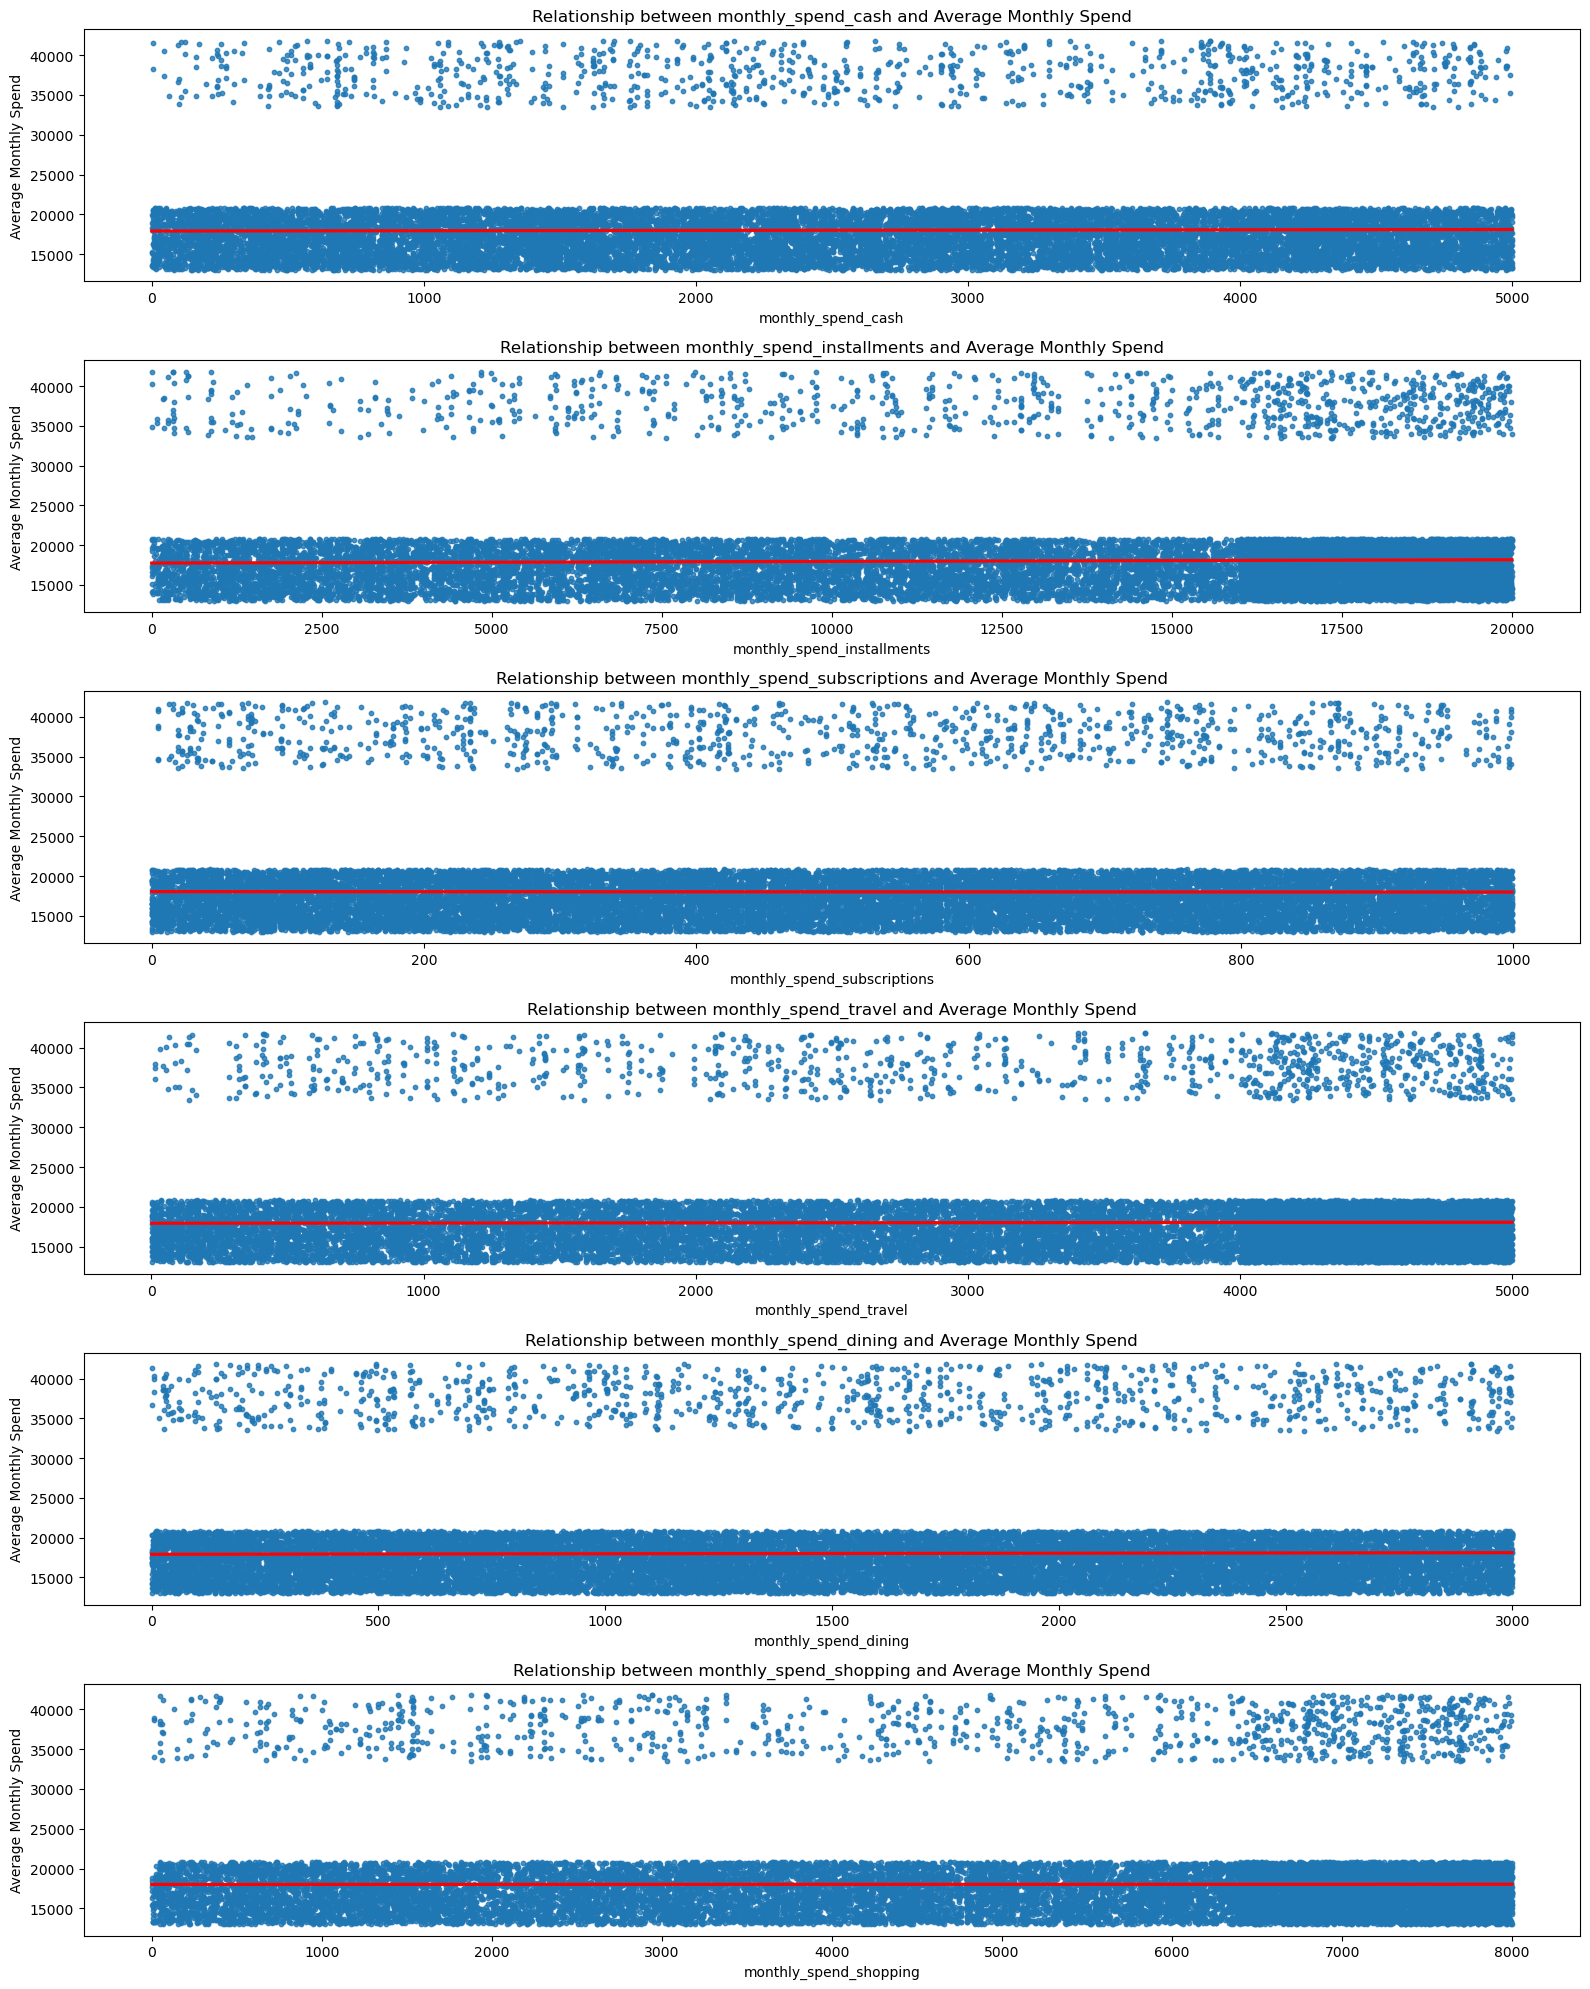

In [86]:
plt.figure(figsize=(16, 20))

for i, col in enumerate(spending_features):
    plt.subplot(len(spending_features), 1, i + 1)
    sns.regplot(x=col, y='average_monthly_spend', data=temp_df, scatter_kws={'s': 10}, line_kws={"color": "red"})
    plt.title(f'Relationship between {col} and Average Monthly Spend')
    plt.xlabel(col)
    plt.ylabel('Average Monthly Spend')

plt.tight_layout()
plt.show()

In [87]:
correlations = temp_df[spending_features + ['churn']].corr()['churn'].drop('churn')

print("Correlations of Spending Features with Churn:")
print(correlations)

Correlations of Spending Features with Churn:
monthly_spend_cash            -0.00
monthly_spend_installments     0.00
monthly_spend_subscriptions    0.01
monthly_spend_travel           0.00
monthly_spend_dining          -0.00
monthly_spend_shopping        -0.01
Name: churn, dtype: float64


   average_monthly_transactions transaction_tier
0                            13          0-24.63
1                           170              NaN
2                            12          0-24.63
3                            15          0-24.63
4                            14          0-24.63
  transaction_tier  churn
0          0-24.63   1.00
1    24.64 - 48.85    NaN
2    48.86 - 73.78    NaN
3   73.79 - 107.06    NaN


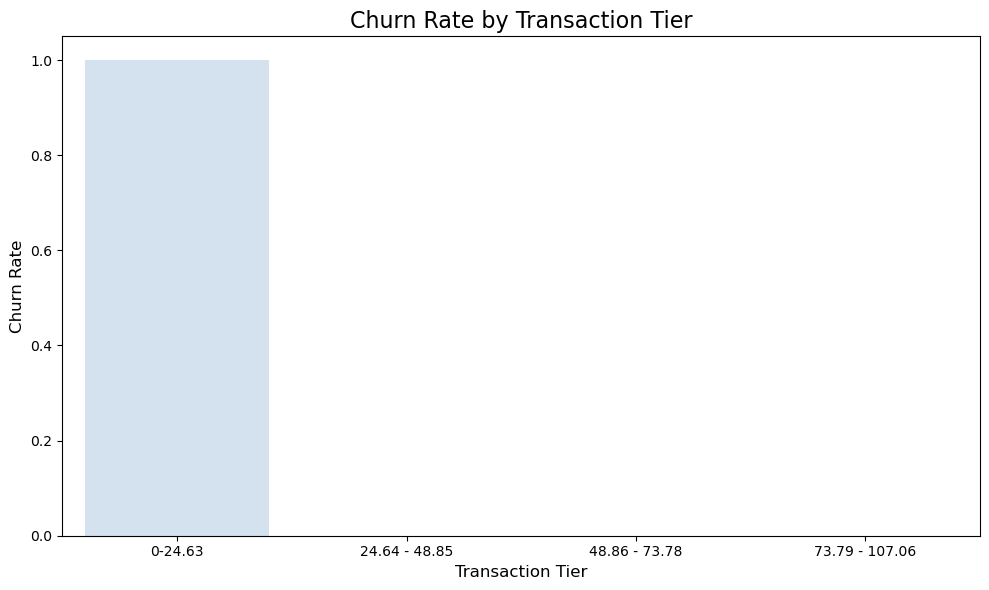

In [88]:
bins = [0, 24.63, 48.85, 73.78, 107.06]
labels = ['0-24.63', '24.64 - 48.85', '48.86 - 73.78', '73.79 - 107.06']

temp_df['transaction_tier'] = pd.cut(temp_df['average_monthly_transactions'], bins=bins, labels=labels, right=True)

print(temp_df[['average_monthly_transactions', 'transaction_tier']].head())

churn_by_tier = temp_df.groupby('transaction_tier')['churn'].mean().reset_index()
print(churn_by_tier)
plt.figure(figsize=(10, 6))
sns.barplot(x='transaction_tier', y='churn', data=churn_by_tier, palette='Blues')
plt.title('Churn Rate by Transaction Tier', fontsize=16)
plt.xlabel('Transaction Tier', fontsize=12)
plt.ylabel('Churn Rate', fontsize=12)
plt.tight_layout()
plt.show()

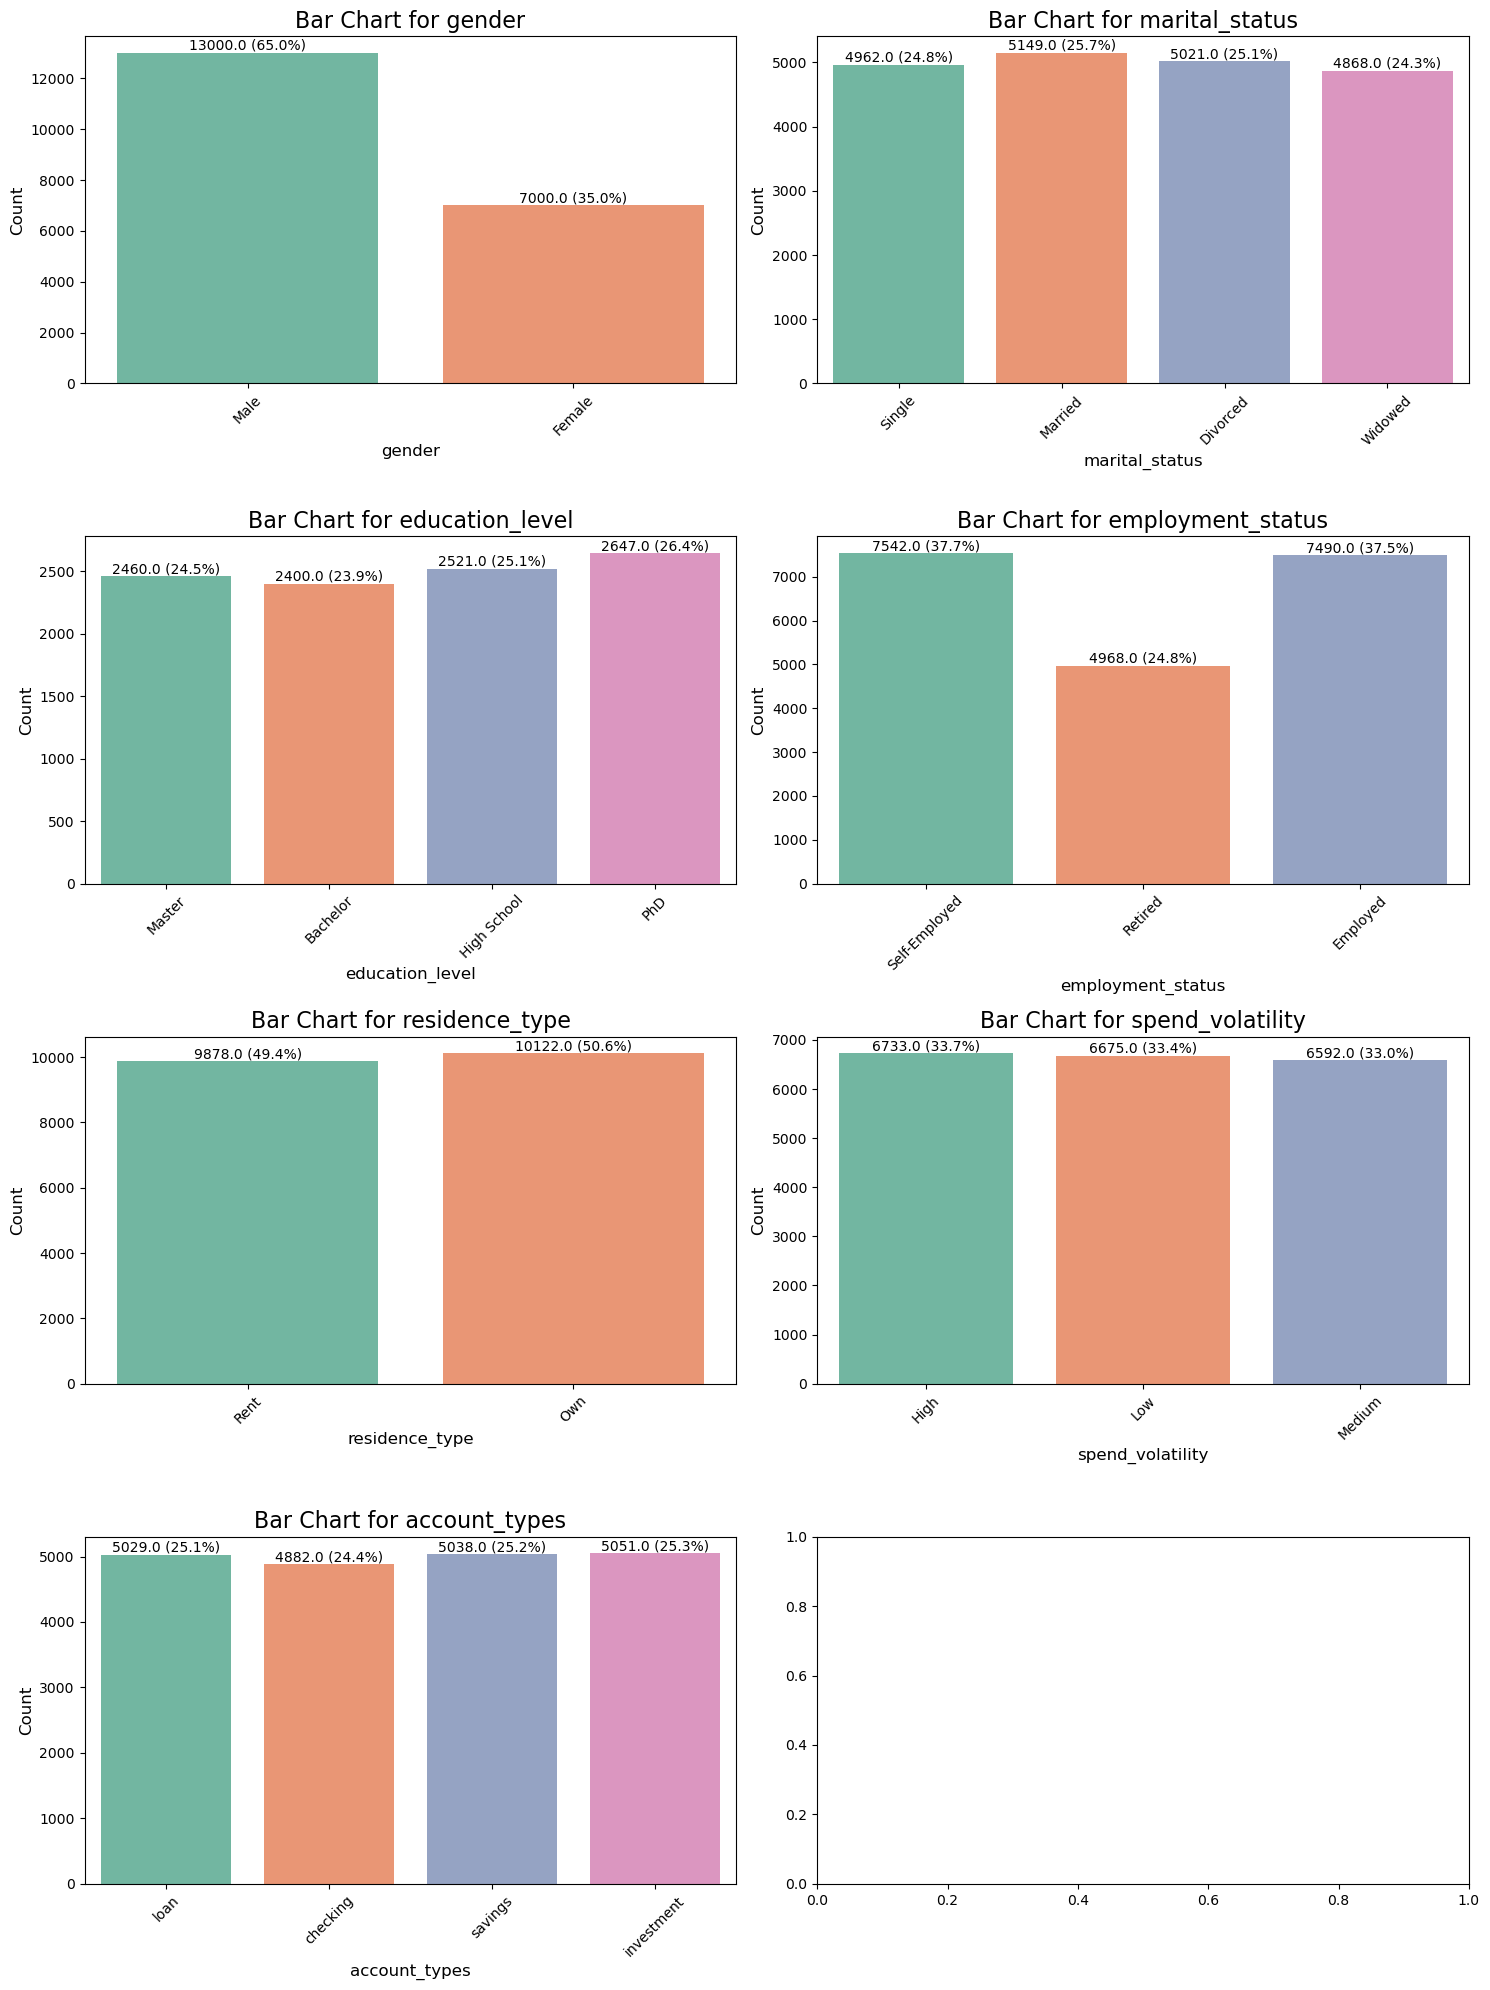

In [89]:
categorical_features = [
    'gender', 'marital_status', 'education_level', 'employment_status',
    'residence_type', 'spend_volatility', 'account_types'
]

num_features = len(categorical_features)
num_cols = 2
num_rows = (num_features + 1) // 2 
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

axs = axs.flatten()

for i, feature in enumerate(categorical_features):
    if feature in temp_df.columns:
        ax = axs[i]
        # Count plot with a new color palette
        sns.countplot(x=feature, data=temp_df, palette='Set2', ax=ax)

        # Calculate total for percentage calculation
        total = temp_df[feature].count()

        for p in ax.patches:
            height = p.get_height()
            percentage = (height / total) * 100
            ax.annotate(f'{height} ({percentage:.1f}%)', 
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        
        ax.set_title(f'Bar Chart for {feature}', fontsize=16)
        ax.set_xlabel(feature, fontsize=12)
        ax.set_ylabel('Count', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
    else:
        print(f"Feature '{feature}' does not exist in the DataFrame.")

plt.tight_layout()
plt.show()

In [90]:
temp_df

index  age  gender marital_status education_level employment_status  \
0       5464   22    Male         Single          Master     Self-Employed   
1       2042   25    Male        Married             NaN           Retired   
2       8669   64  Female       Divorced        Bachelor          Employed   
3       1115   61  Female         Single          Master          Employed   
4       4078   58    Male        Married             NaN     Self-Employed   
...      ...  ...     ...            ...             ...               ...   
19995   7392   34  Female        Widowed          Master           Retired   
19996   2944   25    Male        Married             NaN          Employed   
19997   5391   39    Male        Married        Bachelor     Self-Employed   
19998    861   51    Male       Divorced             PhD          Employed   
19999   4096   53  Female        Married          Master          Employed   

       num_dependents residence_type  years_at_residence  monthly_spend_cash  \
0                   3           Rent                   3             4664.00   
1                   2           Rent                   1                 NaN   
2                   4            Own                   8             1408.00   
3                   2            Own                   8                 NaN   
4                   1           Rent                  14             4134.00   
...               ...            ...                 ...                 ...   
19995               2           Rent                  13                 NaN   
19996               4            Own                  15                 NaN   
19997               1           Rent                   1              283.00   
19998               0            Own                  15             4999.00   
19999               4           Rent                   8             4790.00   

       ...  monthly_active_days  num_other_products  account_types  \
0      ...                 0.54                   4           loan   
1      ...                 2.92                  40       checking   
2      ...                 0.71                   7       checking   
3      ...                 0.94                   4           loan   
4      ...                 2.47                   6       checking   
...    ...                  ...                 ...            ...   
19995  ...                 0.32                  28           loan   
19996  ...                 1.60                  25       checking   
19997  ...                 2.19                   6        savings   
19998  ...                 2.48                   5           loan   
19999  ...                 2.60                  28           loan   

       loyalty_score  transaction_frequency  total_bank_balance  act_ref_num  \
0             251.70                     44           514953.50     SR010651   
1                NaN                     24                 NaN     SR002042   
2              93.90                     42           238569.72     SR008669   
3                NaN                     10                 NaN     SR001115   
4             266.70                     39           291044.97     SR013903   
...              ...                    ...                 ...          ...   
19995            NaN                     38                 NaN     SR011285   
19996            NaN                     15                 NaN     SR011965   
19997         122.15                     23           202200.07     SR005391   
19998         461.95                     29           448988.34     SR000861   
19999         279.00                     32           427174.63     SR015796   

        plastic_masked_pan  age_tier  transaction_tier  
0      **** **** **** 4691     18-24           0-24.63  
1      **** **** **** 4806     18-24               NaN  
2      **** **** **** 2237     60-64           0-24.63  
3      **** **** **** 6982     60-64           0-24.63  
4      **** **** **** 

In [91]:
temp_df.dtypes

index                                    int64
age                                      int64
gender                                  object
marital_status                          object
education_level                         object
employment_status                       object
num_dependents                           int64
residence_type                          object
years_at_residence                       int64
monthly_spend_cash                     float64
monthly_spend_payments                 float64
monthly_spend_installments             float64
monthly_spend_subscriptions              int64
monthly_spend_travel                   float64
monthly_spend_dining                     int64
monthly_spend_shopping                 float64
total_spend_last_month                   int64
total_spend_last_3_months              float64
total_spend_last_6_months              float64
total_spend_last_year                  float64
average_monthly_spend                  float64
max_monthly_s

In [92]:
data_encoded = pd.get_dummies(temp_df, columns=['gender','marital_status','education_level','employment_status','residence_type','account_types'], prefix=['gender','marital_status','education_level','employment_status','residence_type','account_types'])
data_encoded.head()

index  age  num_dependents  years_at_residence  monthly_spend_cash  \
0   5464   22               3                   3             4664.00   
1   2042   25               2                   1                 NaN   
2   8669   64               4                   8             1408.00   
3   1115   61               2                   8                 NaN   
4   4078   58               1                  14             4134.00   

   monthly_spend_payments  monthly_spend_installments  \
0                 7438.00                    15398.00   
1                 8252.00                    18864.43   
2                 5199.00                     4964.00   
3                 1837.00                    18270.00   
4                 7530.00                    18272.78   

   monthly_spend_subscriptions  monthly_spend_travel  monthly_spend_dining  \
0                          760               4884.06                  2211   
1                          665               2970.00                   920   
2                          882               1167.00                  2418   
3                          722               4808.28                    43   
4                          166               3256.00                  2736   

   ...  education_level_PhD  employment_status_Employed  \
0  ...                    0                           0   
1  ...                    0                           0   
2  ...                    0                           1   
3  ...                    0                           1   
4  ...                    0                           0   

   employment_status_Retired  employment_status_Self-Employed  \
0                          0                                1   
1                          1                                0   
2                          0                                0   
3                          0                                0   
4                          0                                1   

   residence_type_Own  residence_type_Rent  account_types_checking  \
0                   0                    1                       0   
1                   0                    1                       1   
2                   1                    0                       1   
3                   1                    0                       0   
4                   0                    1                       1   

   account_types_investment  account_types_loan  account_types_savings  
0                         0                   1                      0  
1                         0                   0                      0  
2                         0                   0                      0  
3                         0                   1                      0  
4                         0                   0                      0  

[5 rows x 70 columns]

In [93]:
data_encoded.columns

Index(['index', 'age', 'num_dependents', 'years_at_residence',
       'monthly_spend_cash', 'monthly_spend_payments',
       'monthly_spend_installments', 'monthly_spend_subscriptions',
       'monthly_spend_travel', 'monthly_spend_dining',
       'monthly_spend_shopping', 'total_spend_last_month',
       'total_spend_last_3_months', 'total_spend_last_6_months',
       'total_spend_last_year', 'average_monthly_spend', 'max_monthly_spend',
       'min_monthly_spend', 'average_transaction_value',
       'num_transactions_last_month', 'num_transactions_last_3_months',
       'num_transactions_last_6_months', 'num_transactions_last_year',
       'average_monthly_transactions', 'max_monthly_transactions',
       'min_monthly_transactions', 'decreasing_spend_trend',
       'spend_volatility', 'recent_large_transactions',
       'use_of_credit_card_for_emergencies', 'frequent_late_payments', 'churn',
       'expiration_date', 'acc_ref_num', 'previous_cards',
       'longevity_in_months', 'fea

In [94]:
spend_volatility_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}
data_encoded['spend_volatility'] = data_encoded['spend_volatility'].map(spend_volatility_mapping)

In [95]:
data_encoded = data_encoded.set_index('acc_ref_num')
data_encoded

index  age  num_dependents  years_at_residence  \
acc_ref_num                                                       
952044000000.00   5464   22               3                   3   
878090000000.00   2042   25               2                   1   
653734000000.00   8669   64               4                   8   
215640000000.00   1115   61               2                   8   
350624000000.00   4078   58               1                  14   
...                ...  ...             ...                 ...   
540394000000.00   7392   34               2                  13   
447667000000.00   2944   25               4                  15   
520429000000.00   5391   39               1                   1   
304060000000.00    861   51               0                  15   
395635000000.00   4096   53               4                   8   

                 monthly_spend_cash  monthly_spend_payments  \
acc_ref_num                                                   
952044000000.00             4664.00                 7438.00   
878090000000.00                 NaN                 8252.00   
653734000000.00             1408.00                 5199.00   
215640000000.00                 NaN                 1837.00   
350624000000.00             4134.00                 7530.00   
...                             ...                     ...   
540394000000.00                 NaN                 2869.00   
447667000000.00                 NaN                 3987.00   
520429000000.00              283.00                 1919.00   
304060000000.00             4999.00                 8151.00   
395635000000.00             4790.00                     NaN   

                 monthly_spend_installments  monthly_spend_subscriptions  \
acc_ref_num                                                                
952044000000.00                    15398.00                          760   
878090000000.00                    18864.43                          665   
653734000000.00                     4964.00                          882   
215640000000.00                    18270.00                          722   
350624000000.00                    18272.78                          166   
...                                     ...                          ...   
540394000000.00                     3369.00                          683   
447667000000.00                    19475.27                          528   
520429000000.00                    18531.31                          478   
304060000000.00                    15278.00                          394   
395635000000.00                    19817.76                          453   

                 monthly_spend_travel  monthly_spend_dining  ...  \
acc_ref_num                                                  ...   
952044000000.00               4884.06                  2211  ...   
878090000000.00               2970.00                   920  ...   
653734000000.00               1167.00                  2418  ...   
215640000000.00               4808.28                    43  ...   
350624000000.00               3256.00                  2736  ...   
...                               ...                   ...  ...   
540394000000.00               2247.00                  1953  ...   
447667000000.00                 70.00                  1927  ...   
520429000000.00                 61.00                   743  ...   
304060000000.00                784.00                  1219  ...   
395635000000.00               3932.00                  2103  ...   

                 education_level_PhD  employment_status_Employed  \
acc_ref_num                                                        
952044000000.00                    0                           0   
878090000000.00                    0                           0   
653734000000.00                    0                           1   
215640000000.00                    0                           1   
350624000000.00                    0       

In [96]:
data_encoded.drop(['index', 'act_ref_num', 'plastic_masked_pan', 'age_tier', 'transaction_tier','feature_1','feature_2','feature_3'],axis=1 , inplace=True)

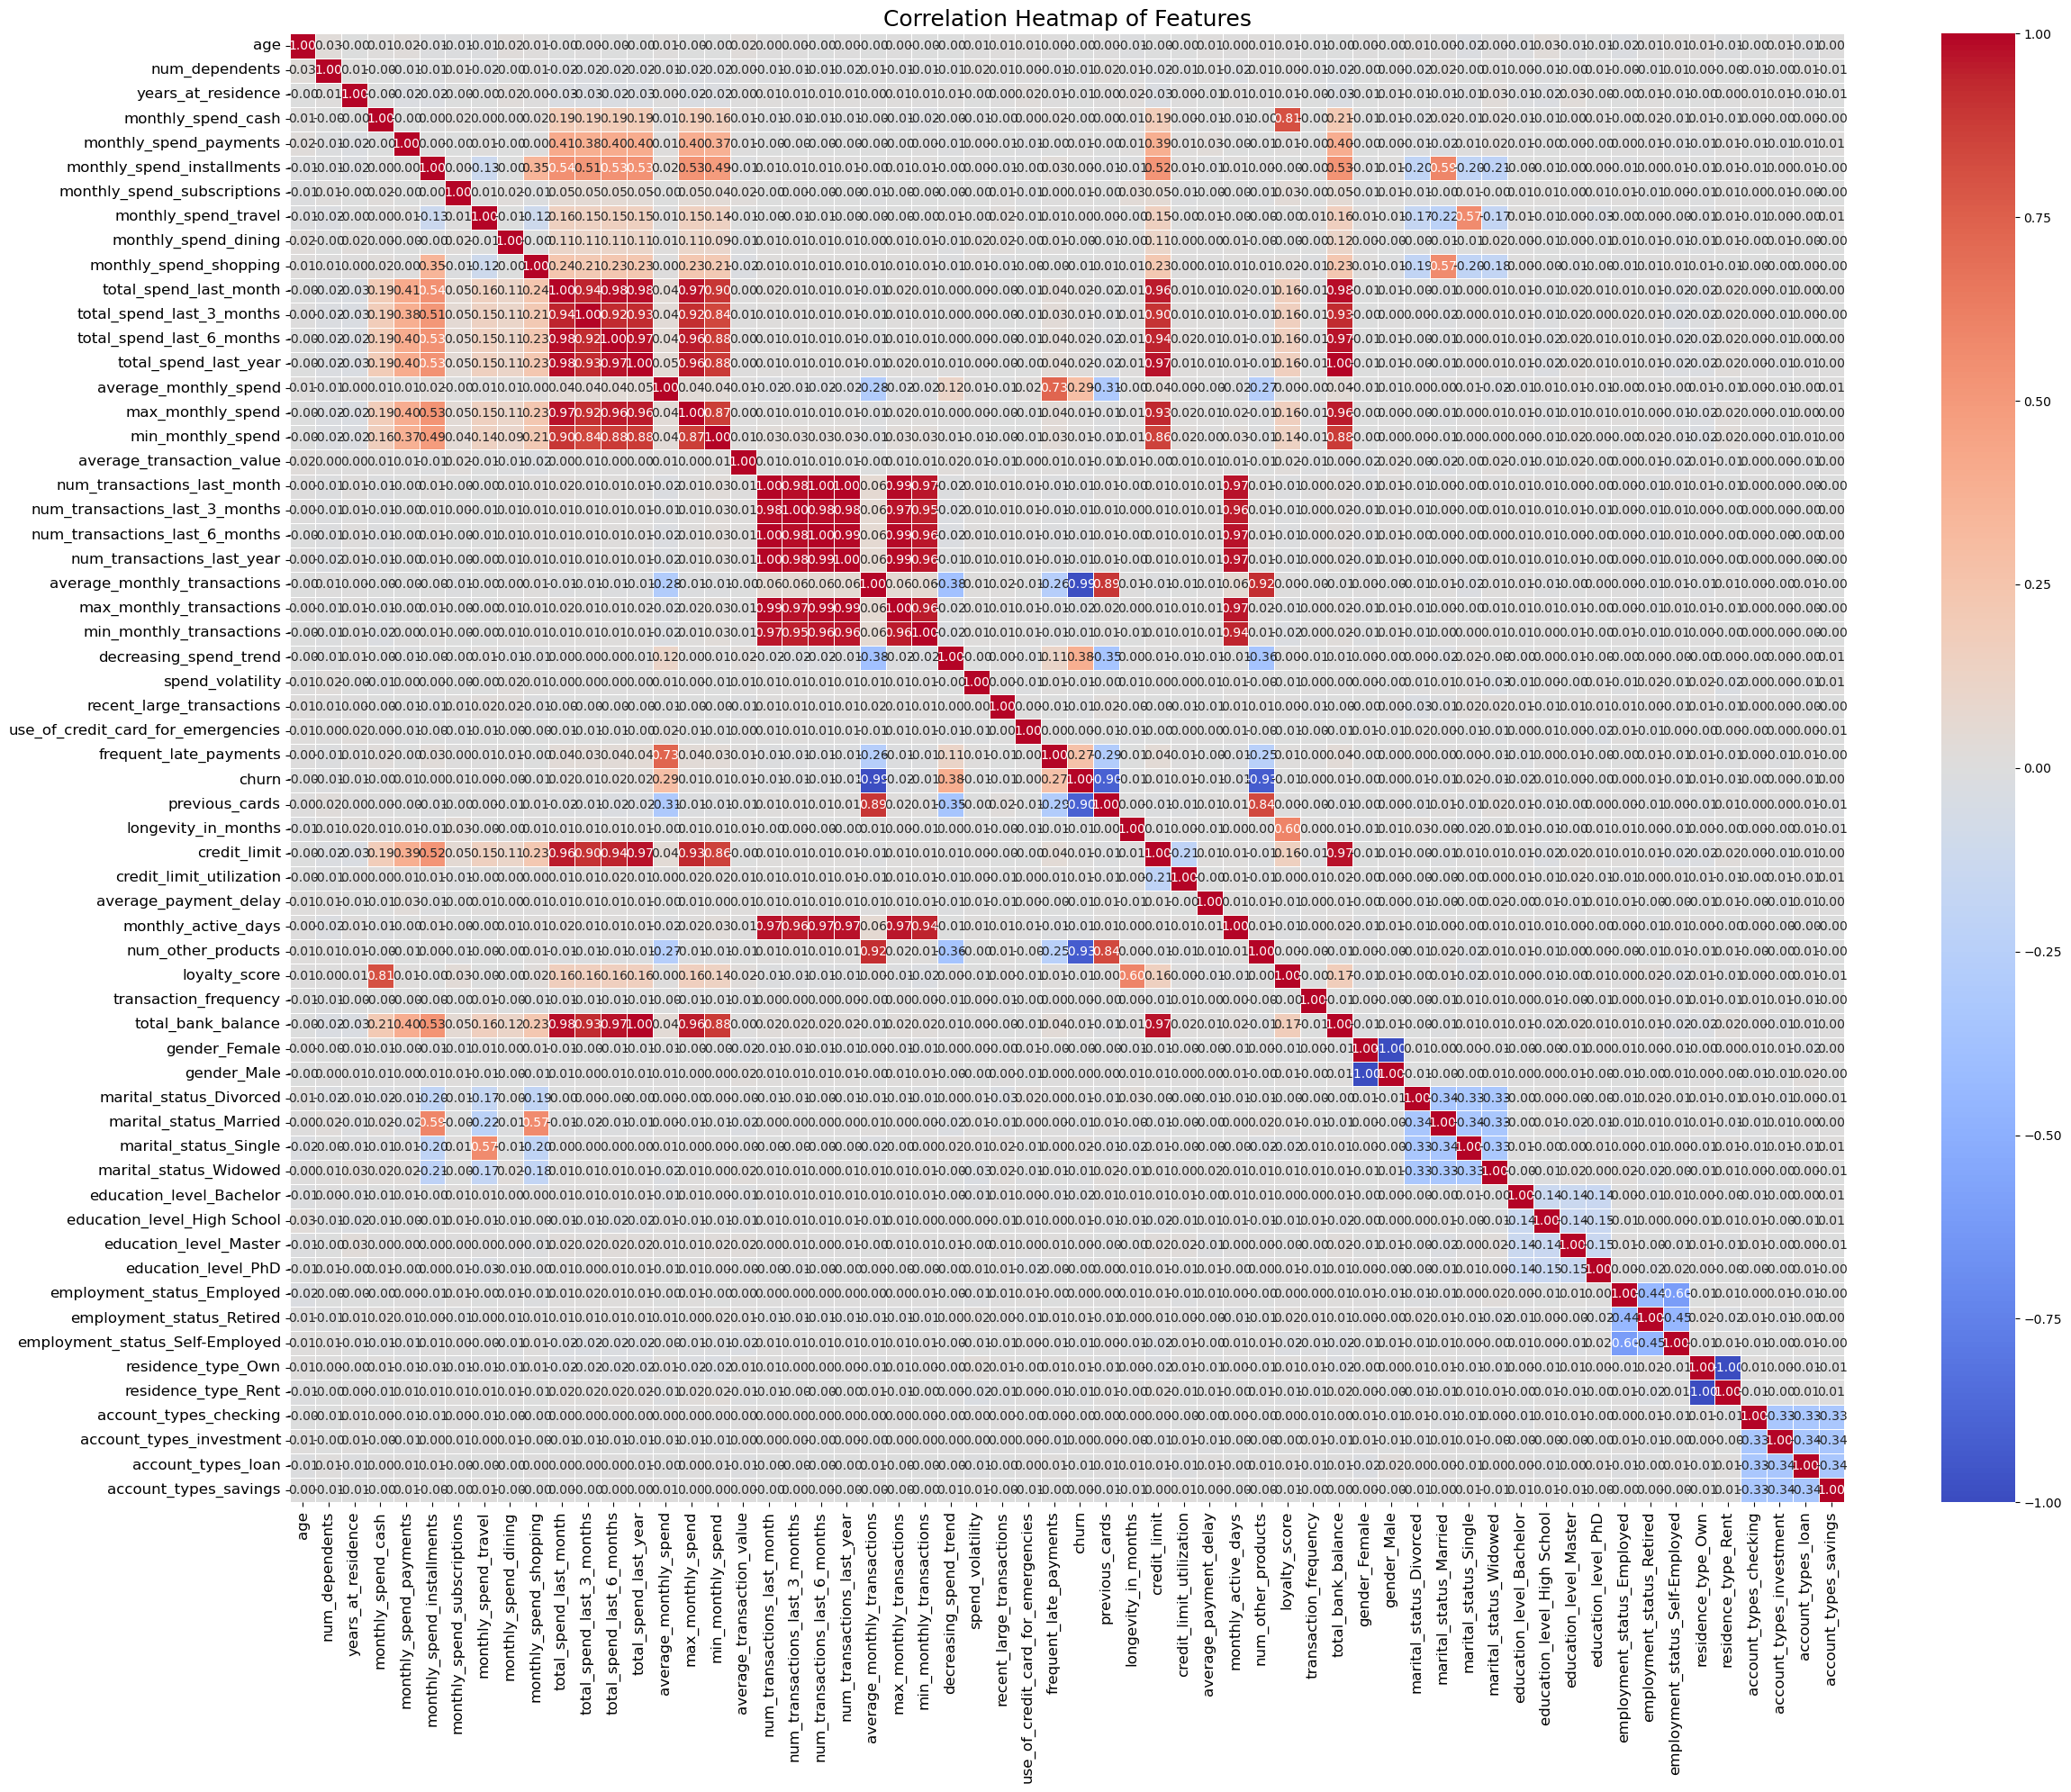

In [97]:
corr_matrix = data_encoded.corr()

plt.figure(figsize=(25, 20))

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)

plt.title('Correlation Heatmap of Features', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Data preprocessing

In [98]:
columns_to_fill = [
    'monthly_spend_cash', 
    'monthly_spend_payments', 
    'monthly_spend_installments'
]

data_encoded[columns_to_fill] = data_encoded[columns_to_fill].fillna(0)

In [99]:
data_encoded['average_monthly_spend'] = data_encoded.apply(
    lambda row: (row['max_monthly_spend'] + row['min_monthly_spend']) / 2 
    if pd.isna(row['average_monthly_spend']) 
    else row['average_monthly_spend'], 
    axis=1
)

In [100]:
data_encoded['average_transaction_value'] = data_encoded.apply(
    lambda row: row['total_spend_last_month'] / row['num_transactions_last_month'] 
    if pd.isna(row['average_transaction_value']) and row['num_transactions_last_month'] > 0 
    else row['average_transaction_value'], 
    axis=1
)

In [101]:
data_encoded['expiration_date'] = pd.to_datetime(data_encoded['expiration_date'], errors='coerce')
current_date = datetime.now()
data_encoded['months_until_expiration'] = (data_encoded['expiration_date'] - current_date) // pd.Timedelta(days=30)

In [102]:
data_encoded.drop('expiration_date',axis=1,inplace=True)

In [103]:
duplicates = data_encoded.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

Number of duplicate rows: 0


In [104]:
data_encoded.isna().sum()

age                         0
num_dependents              0
years_at_residence          0
monthly_spend_cash          0
monthly_spend_payments      0
                           ..
account_types_checking      0
account_types_investment    0
account_types_loan          0
account_types_savings       0
months_until_expiration     0
Length: 61, dtype: int64

In [105]:
data_encoded.dropna(inplace=True)

# Data quality check

In [106]:
summary_statistics = data_encoded.describe()
print("Summary Statistics:\n", summary_statistics)

Summary Statistics:
            age  num_dependents  years_at_residence  monthly_spend_cash  \
count 17985.00        17985.00            17985.00            17985.00   
mean     43.45            2.00               15.00             2517.59   
std      14.93            1.41                8.37             1445.05   
min      18.00            0.00                1.00                0.00   
25%      31.00            1.00                8.00             1281.00   
50%      43.00            2.00               15.00             2489.00   
75%      56.00            3.00               22.00             3803.00   
max      69.00            4.00               29.00             4999.00   

       monthly_spend_payments  monthly_spend_installments  \
count                17985.00                    17985.00   
mean                  4569.92                    11302.54   
std                   3148.13                     6701.32   
min                      0.00                        0.00   
25%    

In [107]:
print(data_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 17985 entries, 952044000000.0 to 395635000000.0
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   age                                 17985 non-null  int64  
 1   num_dependents                      17985 non-null  int64  
 2   years_at_residence                  17985 non-null  int64  
 3   monthly_spend_cash                  17985 non-null  float64
 4   monthly_spend_payments              17985 non-null  float64
 5   monthly_spend_installments          17985 non-null  float64
 6   monthly_spend_subscriptions         17985 non-null  int64  
 7   monthly_spend_travel                17985 non-null  float64
 8   monthly_spend_dining                17985 non-null  int64  
 9   monthly_spend_shopping              17985 non-null  float64
 10  total_spend_last_month              17985 non-null  int64  
 11  total_spend_last_

# Data Splitting,Sampling & Modelling trials 

In [108]:
X = data_encoded.drop(columns=['churn'])
y = data_encoded['churn']

In [109]:
df_train, df_temp = train_test_split(data_encoded, train_size=0.7, stratify=y, random_state=42)
df_validate, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['churn'], random_state=42)

In [138]:
X_train = df_train.drop(columns=['churn'])
y_train = df_train['churn']
X_validate = df_validate.drop(columns=['churn'])
y_validate = df_validate['churn']
X_test = df_test.drop(columns=['churn'])
y_test = df_test['churn']

###     Without balancing methods

In [139]:
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression()

In [140]:
train_preds = log_reg.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.70      0.92      0.79      8174
           1       0.64      0.25      0.36      4415

    accuracy                           0.69     12589
   macro avg       0.67      0.59      0.58     12589
weighted avg       0.68      0.69      0.64     12589



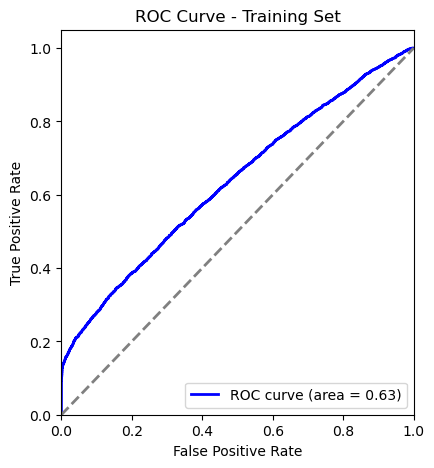

In [150]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, RocCurveDisplay

fpr_train, tpr_train, _ = roc_curve(y_train, log_reg.predict_proba(X_train)[:, 1])
roc_auc_train = auc(fpr_train, tpr_train)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Set')
plt.legend(loc="lower right")

In [141]:
val_preds = log_reg.predict(X_validate)
print(classification_report(y_validate, val_preds))

              precision    recall  f1-score   support

           0       0.69      0.93      0.79      1752
           1       0.64      0.25      0.36       946

    accuracy                           0.69      2698
   macro avg       0.67      0.59      0.58      2698
weighted avg       0.68      0.69      0.64      2698



In [151]:
test_preds = log_reg.predict(X_test)
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.69      0.92      0.79      1752
           1       0.61      0.24      0.35       946

    accuracy                           0.68      2698
   macro avg       0.65      0.58      0.57      2698
weighted avg       0.66      0.68      0.63      2698



In [143]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [144]:
log_reg_weighted = LogisticRegression(class_weight=class_weights_dict)
log_reg_weighted.fit(X_train,y_train)

LogisticRegression(class_weight={0: 0.7700636163445069, 1: 1.4257078142695356})

In [145]:
train_preds = log_reg_weighted.predict(X_train)
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.75      0.66      0.71      8174
           1       0.49      0.60      0.54      4415

    accuracy                           0.64     12589
   macro avg       0.62      0.63      0.62     12589
weighted avg       0.66      0.64      0.65     12589



In [146]:
val_preds = log_reg_weighted.predict(X_validate)
print(classification_report(y_validate, val_preds))

              precision    recall  f1-score   support

           0       0.76      0.67      0.71      1752
           1       0.49      0.60      0.54       946

    accuracy                           0.64      2698
   macro avg       0.63      0.64      0.63      2698
weighted avg       0.66      0.64      0.65      2698



In [147]:
test_preds_weighted = log_reg_weighted.predict(X_test)
print("Testing set performance with balancing:")
print(classification_report(y_test, test_preds_weighted))

Testing set performance with balancing:
              precision    recall  f1-score   support

           0       0.75      0.66      0.70      1752
           1       0.48      0.59      0.53       946

    accuracy                           0.64      2698
   macro avg       0.62      0.62      0.62      2698
weighted avg       0.66      0.64      0.64      2698



In [122]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from catboost import CatBoostClassifier

In [128]:
# Without class balancing
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)
train_preds = xgb_model.predict(X_train)
print("XGBoost (No Balancing) - Training Report:")
print(classification_report(y_train, train_preds))
val_preds = xgb_model.predict(X_validate)
print("XGBoost (No Balancing) - Validation Report:")
print(classification_report(y_validate, val_preds))
all_preds = xgb_model.predict(X)
print("XGBoost (No Balancing) - Overall Report:")
print(classification_report(y, all_preds))

XGBoost (No Balancing) - Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8174
           1       1.00      1.00      1.00      4415

    accuracy                           1.00     12589
   macro avg       1.00      1.00      1.00     12589
weighted avg       1.00      1.00      1.00     12589

XGBoost (No Balancing) - Validation Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       946

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

XGBoost (No Balancing) - Overall Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11678
           1       1.00      1.00      1.00      6307

    accuracy                           1.00     17985
 

In [129]:
xgb_model_weighted = xgb.XGBClassifier(weights=class_weights_dict)
xgb_model_weighted.fit(X_train, y_train)
train_preds = xgb_model_weighted.predict(X_train)
print("XGBoost (With Balancing) - Training Report:")
print(classification_report(y_train, train_preds))
val_preds = xgb_model_weighted.predict(X_validate)
print("XGBoost (With Balancing) - Validation Report:")
print(classification_report(y_validate, val_preds))
all_preds = xgb_model_weighted.predict(X)
print("XGBoost (With Balancing) - Overall Report:")
print(classification_report(y, all_preds))

XGBoost (With Balancing) - Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8174
           1       1.00      1.00      1.00      4415

    accuracy                           1.00     12589
   macro avg       1.00      1.00      1.00     12589
weighted avg       1.00      1.00      1.00     12589

XGBoost (With Balancing) - Validation Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       946

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

XGBoost (With Balancing) - Overall Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11678
           1       1.00      1.00      1.00      6307

    accuracy                           1.00     1

In [136]:
# Without class balancing
catboost_model = CatBoostClassifier(verbose=0, n_estimators=1700, depth=5)
catboost_model.fit(X_train, y_train)
train_preds = catboost_model.predict(X_train)
print("CatBoost (No Balancing) - Training Report:")
print(classification_report(y_train, train_preds))
val_preds = catboost_model.predict(X_validate)
print("CatBoost (No Balancing) - Validation Report:")
print(classification_report(y_validate, val_preds))
all_preds = catboost_model.predict(X)
print("CatBoost (No Balancing) - Overall Report:")
print(classification_report(y, all_preds))

CatBoost (No Balancing) - Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8174
           1       1.00      1.00      1.00      4415

    accuracy                           1.00     12589
   macro avg       1.00      1.00      1.00     12589
weighted avg       1.00      1.00      1.00     12589

CatBoost (No Balancing) - Validation Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       946

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

CatBoost (No Balancing) - Overall Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11678
           1       1.00      1.00      1.00      6307

    accuracy                           1.00     1798

In [137]:
catboost_model = CatBoostClassifier(class_weights=class_weights, verbose=0, n_estimators=1700, depth=5)
catboost_model_weighted.fit(X_train, y_train)
train_preds = catboost_model_weighted.predict(X_train)
print("CatBoost (With Balancing) - Training Report:")
print(classification_report(y_train, train_preds))
val_preds = catboost_model_weighted.predict(X_validate)
print("CatBoost (With Balancing) - Validation Report:")
print(classification_report(y_validate, val_preds))
all_preds = catboost_model_weighted.predict(X)
print("CatBoost (With Balancing) - Overall Report:")
print(classification_report(y, all_preds))

CatBoost (With Balancing) - Training Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8174
           1       1.00      1.00      1.00      4415

    accuracy                           1.00     12589
   macro avg       1.00      1.00      1.00     12589
weighted avg       1.00      1.00      1.00     12589

CatBoost (With Balancing) - Validation Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1752
           1       1.00      1.00      1.00       946

    accuracy                           1.00      2698
   macro avg       1.00      1.00      1.00      2698
weighted avg       1.00      1.00      1.00      2698

CatBoost (With Balancing) - Overall Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11678
           1       1.00      1.00      1.00      6307

    accuracy                           1.00   

In [66]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, preds = clf.fit(X_train, X_train, y_train, y_train)

 97%|█████████▋| 28/29 [01:14<00:00,  1.02it/s]

[LightGBM] [Info] Number of positive: 4415, number of negative: 8174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6649
[LightGBM] [Info] Number of data points in the train set: 12589, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350703 -> initscore=-0.615951
[LightGBM] [Info] Start training from score -0.615951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

100%|██████████| 29/29 [01:14<00:00,  2.58s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [67]:
print(models)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
SVC                                1.00               1.00     1.00      1.00   
RidgeClassifierCV                  1.00               1.00     1.00      1.00   
RidgeClassifier                    1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
QuadraticDiscriminantAnalysis      1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
PassiveAggressiveClassifier        1.00               1.00     1.00      1.00   
NearestCentroid             

In [68]:
clf0 = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models0, preds = clf.fit(X_train, X_validate, y_train, y_validate)

'tuple' object has no attribute '__name__'
Invalid Classifier(s)


 97%|█████████▋| 28/29 [00:52<00:00,  1.15it/s]

[LightGBM] [Info] Number of positive: 4415, number of negative: 8174
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003550 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6649
[LightGBM] [Info] Number of data points in the train set: 12589, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.350703 -> initscore=-0.615951
[LightGBM] [Info] Start training from score -0.615951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

100%|██████████| 29/29 [00:53<00:00,  1.83s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [69]:
print(models0)

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
AdaBoostClassifier                 1.00               1.00     1.00      1.00   
BaggingClassifier                  1.00               1.00     1.00      1.00   
XGBClassifier                      1.00               1.00     1.00      1.00   
RidgeClassifierCV                  1.00               1.00     1.00      1.00   
RidgeClassifier                    1.00               1.00     1.00      1.00   
RandomForestClassifier             1.00               1.00     1.00      1.00   
QuadraticDiscriminantAnalysis      1.00               1.00     1.00      1.00   
Perceptron                         1.00               1.00     1.00      1.00   
PassiveAggressiveClassifier        1.00               1.00     1.00      1.00   
NuSVC                              1.00               1.00     1.00      1.00   
NearestCentroid             

In [153]:
counter = collections.Counter(y_train)
print("Original class distribution:", counter)

Original class distribution: Counter({0: 8174, 1: 4415})


In [154]:
over = ADASYN(sampling_strategy=0.45)
under = RandomUnderSampler(sampling_strategy=0.55)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps)

In [155]:
X_train_sampled, y_train_sampled = pipeline.fit_resample(X_train, y_train)

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

In [156]:
counter = collections.Counter(y_train_sampled)
print("Resampled class distribution:", counter)

NameError: name 'y_train_sampled' is not defined

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from catboost import CatBoostClassifier

In [ ]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
class_weights

array([0.52717755, 9.69876733])

In [ ]:
models = {
    'Logistic Regression': LogisticRegression(class_weight=class_weights_dict),
    # 'Bernoulli NB': BernoulliNB(),
    # 'Bagging Classifier': BaggingClassifier(),
    # 'XGB Classifier': XGBClassifier(),
    # 'Random Forest Classifier': RandomForestClassifier(class_weight=weights_dict),
    'CatBoost Classifier' : CatBoostClassifier(class_weights=class_weights, verbose=0, n_estimators=300, depth=5),
    #'Support Vector Machine' : SVC(class_weight=class_weights_dict, probability=True)
}

In [ ]:
catboost_model = CatBoostClassifier(class_weights=class_weights, verbose=0, n_estimators=1700, depth=3)
svm_model = SVC(class_weight=class_weights_dict, probability=True)

# Create StackingClassifier
estimators = [
    ('catboost', catboost_model),
    ('svm', svm_model)
]

In [ ]:
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(class_weight=class_weights_dict))

In [ ]:
stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('catboost',
                                <catboost.core.CatBoostClassifier object at 0x000001D3751C3E50>),
                               ('svm',
                                SVC(class_weight={0: 0.5271775544388609,
                                                  1: 9.698767334360555},
                                    probability=True))],
                   final_estimator=LogisticRegression(class_weight={0: 0.5271775544388609,
                                                                    1: 9.698767334360555}))

In [ ]:
y_pred_train = stacking_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
class_report_train = classification_report(y_train, y_pred_train)

In [ ]:
print("Training Data Results:")
print(f"Accuracy: {accuracy_train:.4f}")
print("Classification Report:")
print(class_report_train)
print("-" * 60)

Training Data Results:
Accuracy: 0.9494
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     11940
           1       0.50      1.00      0.67       649

    accuracy                           0.95     12589
   macro avg       0.75      0.97      0.82     12589
weighted avg       0.97      0.95      0.96     12589

------------------------------------------------------------


In [ ]:
y_pred_validate = stacking_model.predict(X_validate)
accuracy_validate = accuracy_score(y_validate, y_pred_validate)
class_report_validate = classification_report(y_validate, y_pred_validate)

print("Validation Data Results:")
print(f"Accuracy: {accuracy_validate:.4f}")
print("Classification Report:")
print(class_report_validate)
print("=" * 60)

Validation Data Results:
Accuracy: 0.9040
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.91      0.95      2559
           1       0.31      0.71      0.43       139

    accuracy                           0.90      2698
   macro avg       0.65      0.81      0.69      2698
weighted avg       0.95      0.90      0.92      2698



In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
voting_model = VotingClassifier(estimators=[
    ('catboost', catboost_model),
    ('svm', svm_model)
], voting='soft')

# Train VotingClassifier
voting_model.fit(X_train, y_train)

# Evaluate model on training data
y_pred_train = voting_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_pred_train)
class_report_train = classification_report(y_train, y_pred_train)

print("Training Data Results:")
print(f"Accuracy: {accuracy_train:.4f}")
print("Classification Report:")
print(class_report_train)
print("-" * 60)

# Evaluate model on validation data
y_pred_validate = voting_model.predict(X_validate)
accuracy_validate = accuracy_score(y_validate, y_pred_validate)
class_report_validate = classification_report(y_validate, y_pred_validate)

print("Validation Data Results:")
print(f"Accuracy: {accuracy_validate:.4f}")
print("Classification Report:")
print(class_report_validate)
print("=" * 60)

NameError: name 'VotingClassifier' is not defined

In [ ]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train, y_pred_train)
    class_report_train = classification_report(y_train, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.0516
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11940
           1       0.05      1.00      0.10       649

    accuracy                           0.05     12589
   macro avg       0.03      0.50      0.05     12589
weighted avg       0.00      0.05      0.01     12589

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.0515
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2559
           1       0.05      1.00      0.10       139

    accuracy                           0.05      2698
   macro avg       0.03      0.50      0.05      2698
weighted avg       0.00      0.05      0.01      2698

Model: CatBoost Classifier
Training Data Results:
Accuracy: 0.9915
Classification Report:
              precision    recall  f1-sc

In [ ]:
for name, model in models.items():
    model.fit(X_train_sampled, y_train_sampled)
    y_pred_train = model.predict(X_train_sampled)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_sampled, y_pred_train)
    class_report_train = classification_report(y_train_sampled, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: CatBoost Classifier
Training Data Results:
Accuracy: 0.8795
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90      9983
           1       0.75      1.00      0.85      5491

    accuracy                           0.88     15474
   macro avg       0.87      0.91      0.88     15474
weighted avg       0.91      0.88      0.88     15474

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.7832
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2559
           1       0.15      0.71      0.25       139

    accuracy                           0.78      2698
   macro avg       0.57      0.75      0.56      2698
weighted avg       0.94      0.78      0.84      2698

Model: Support Vector Machine
Training Data Results:
Accuracy: 0.3549
Classification Report:
              precision    recall  f1

## Oversampling

In [ ]:
ros = RandomOverSampler(random_state=42)
X_train_resampled1, y_train_resampled1 = ros.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled1, y_train_resampled1)
    y_pred_train = model.predict(X_train_resampled1)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled1, y_pred_train)
    class_report_train = classification_report(y_train_resampled1, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11949
           1       0.50      1.00      0.67     11949

    accuracy                           0.50     23898
   macro avg       0.25      0.50      0.33     23898
weighted avg       0.25      0.50      0.33     23898

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.0586
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2540
           1       0.06      1.00      0.11       158

    accuracy                           0.06      2698
   macro avg       0.03      0.50      0.06      2698
weighted avg       0.00      0.06      0.01      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.5598
Classification Report:
              precision    recall  f1-score   s

In [ ]:
def smoothed_bootstrap_oversampling(X, y, random_state=None):
    if random_state:
        np.random.seed(random_state)
    
    X_resampled = []
    y_resampled = []
    
    for class_value in np.unique(y):
        X_class = X[y == class_value]
        n_samples = len(X_class)
        
        bootstrap_samples = X_class[np.random.choice(n_samples, size=n_samples, replace=True)]
        noise = np.random.normal(loc=0.0, scale=0.01, size=bootstrap_samples.shape)
        X_class_resampled = bootstrap_samples + noise
        
        X_resampled.append(X_class_resampled)
        y_resampled.append([class_value] * n_samples)
    
    X_resampled = np.vstack(X_resampled)
    y_resampled = np.hstack(y_resampled)
    
    return X_resampled, y_resampled

In [ ]:
X_train_resampled2, y_train_resampled2 = smoothed_bootstrap_oversampling(X_train.values, y_train.values, random_state=42)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled2, y_train_resampled2)
    y_pred_train = model.predict(X_train_resampled2)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled2, y_pred_train)
    class_report_train = classification_report(y_train_resampled2, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.9492
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11949
           1       0.00      0.00      0.00       640

    accuracy                           0.95     12589
   macro avg       0.47      0.50      0.49     12589
weighted avg       0.90      0.95      0.92     12589

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.9485
Classification Report:
              precision    recall  f1-score   s

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled3, y_train_resampled3 = smote.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled3, y_train_resampled3)
    y_pred_train = model.predict(X_train_resampled3)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled3, y_pred_train)
    class_report_train = classification_report(y_train_resampled3, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11949
           1       0.50      1.00      0.67     11949

    accuracy                           0.50     23898
   macro avg       0.25      0.50      0.33     23898
weighted avg       0.25      0.50      0.33     23898

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.0586
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2540
           1       0.06      1.00      0.11       158

    accuracy                           0.06      2698
   macro avg       0.03      0.50      0.06      2698
weighted avg       0.00      0.06      0.01      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.8209
Classification Report:
              precision    recall  f1-score   s

In [ ]:
adasyn = ADASYN(random_state=42)
X_train_resampled4, y_train_resampled4 = adasyn.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled4, y_train_resampled4)
    y_pred_train = model.predict(X_train_resampled4)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled4, y_pred_train)
    class_report_train = classification_report(y_train_resampled4, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.4998
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     11949
           1       0.50      1.00      0.67     11939

    accuracy                           0.50     23888
   macro avg       0.25      0.50      0.33     23888
weighted avg       0.25      0.50      0.33     23888

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.0586
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2540
           1       0.06      1.00      0.11       158

    accuracy                           0.06      2698
   macro avg       0.03      0.50      0.06      2698
weighted avg       0.00      0.06      0.01      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.8364
Classification Report:
              precision    recall  f1-score   s

## Under sampling

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_train_resampled5, y_train_resampled5 = rus.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled5, y_train_resampled5)
    y_pred_train = model.predict(X_train_resampled5)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled5, y_pred_train)
    class_report_train = classification_report(y_train_resampled5, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       640
           1       0.00      0.00      0.00       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.5664
Classification Report:
              precision    recall  f1-score   s

In [ ]:
nm1 = NearMiss(version=1)
X_train_resampled6, y_train_resampled6 = nm1.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled6, y_train_resampled6)
    y_pred_train = model.predict(X_train_resampled6)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled6, y_pred_train)
    class_report_train = classification_report(y_train_resampled6, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       640
           1       0.50      1.00      0.67       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.0586
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2540
           1       0.06      1.00      0.11       158

    accuracy                           0.06      2698
   macro avg       0.03      0.50      0.06      2698
weighted avg       0.00      0.06      0.01      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.5727
Classification Report:
              precision    recall  f1-score   s

In [ ]:
nm2= NearMiss(version=2)
X_train_resampled7, y_train_resampled7 = nm2.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled7, y_train_resampled7)
    y_pred_train = model.predict(X_train_resampled7)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled7, y_pred_train)
    class_report_train = classification_report(y_train_resampled7, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       640
           1       0.00      0.00      0.00       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.5914
Classification Report:
              precision    recall  f1-score   s

In [ ]:
nm3= NearMiss(version=3)
X_train_resampled8, y_train_resampled8 = nm3.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled8, y_train_resampled8)
    y_pred_train = model.predict(X_train_resampled8)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled8, y_pred_train)
    class_report_train = classification_report(y_train_resampled8, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.5000
Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       640
           1       0.00      0.00      0.00       640

    accuracy                           0.50      1280
   macro avg       0.25      0.50      0.33      1280
weighted avg       0.25      0.50      0.33      1280

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.5766
Classification Report:
              precision    recall  f1-score   s

In [ ]:
tl = TomekLinks()
X_train_resampled9, y_train_resampled9 = tl.fit_resample(X_train, y_train)

In [ ]:
for name, model in models.items():
    model.fit(X_train_resampled9, y_train_resampled9)
    y_pred_train = model.predict(X_train_resampled9)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_resampled9, y_pred_train)
    class_report_train = classification_report(y_train_resampled9, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.9489
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     11876
           1       0.00      0.00      0.00       640

    accuracy                           0.95     12516
   macro avg       0.47      0.50      0.49     12516
weighted avg       0.90      0.95      0.92     12516

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.9488
Classification Report:
              precision    recall  f1-score   s

## Pipeline

Original class distribution: Counter({0: 11949, 1: 640})


Resampled class distribution: Counter({0: 9949, 1: 5472})


In [ ]:
for name, model in models.items():
    model.fit(X_train_sampled, y_train_sampled)
    y_pred_train = model.predict(X_train_sampled)
    y_pred_validate = model.predict(X_validate)
    
    accuracy_train = accuracy_score(y_train_sampled, y_pred_train)
    class_report_train = classification_report(y_train_sampled, y_pred_train)
    
    accuracy_validate = accuracy_score(y_validate, y_pred_validate)
    class_report_validate = classification_report(y_validate, y_pred_validate)
    
    print(f"Model: {name}")
    print("Training Data Results:")
    print(f"Accuracy: {accuracy_train:.4f}")
    print("Classification Report:")
    print(class_report_train)
    print("-" * 60)
    print("Validation Data Results:")
    print(f"Accuracy: {accuracy_validate:.4f}")
    print("Classification Report:")
    print(class_report_validate)
    print("=" * 60)

Model: Logistic Regression
Training Data Results:
Accuracy: 0.6452
Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.78      9949
           1       0.00      0.00      0.00      5472

    accuracy                           0.65     15421
   macro avg       0.32      0.50      0.39     15421
weighted avg       0.42      0.65      0.51     15421

------------------------------------------------------------
Validation Data Results:
Accuracy: 0.9414
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2540
           1       0.00      0.00      0.00       158

    accuracy                           0.94      2698
   macro avg       0.47      0.50      0.48      2698
weighted avg       0.89      0.94      0.91      2698

Model: Bernoulli NB
Training Data Results:
Accuracy: 0.8497
Classification Report:
              precision    recall  f1-score   s